## Лабораторная работа № 3. Exploratory Data Analysis и линейная регрессия


### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а также привыкнем к основным понятиям машинного обучения.

<strong style="color: red">Внимание!</strong> В этом ноутбуке используется библиотека `ipyleaflet`. Чтобы ее установить так, чтобы она работала, нужно совершить 2 простых шага:

In [6]:
%%bash
pip3 install ipyleaflet
jupyter nbextension enable --py --sys-prefix ipyleaflet

Couldn't find program: 'bash'


После этого перезапустите сессию (не `Restart Kernel`, а нажмите `Ctrl+C` в терминале, где вы запускали ноутбук, и запустите заново). Лучше это сделать сразу, чтобы потом не пришлось прерывать сессию и терять промежуточные результаты работы. Если все сделано правильно, вы должны увидеть карту Москвы, выполнив ячейку ниже:

In [7]:
from ipyleaflet import Map, basemaps
Map(center=(55.7522200, 37.6155600), zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

Map(center=[55.75222, 37.61556], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0.

**Задание 1.**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
df = pd.read_csv('train.csv', sep=",")
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [11]:
df.shape

(1458644, 11)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [12]:
df = df.drop('dropoff_datetime', axis=1)

In [13]:
df['pickup_datetime']= pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [14]:
total = df.isna().sum().sort_values(ascending=False)
percent = ((df.isna().sum())*100)/df.isna().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data

Total  Percent
id                      0      0.0
vendor_id               0      0.0
pickup_datetime         0      0.0
passenger_count         0      0.0
pickup_longitude        0      0.0
pickup_latitude         0      0.0
dropoff_longitude       0      0.0
dropoff_latitude        0      0.0
store_and_fwd_flag      0      0.0
trip_duration           0      0.0

In [15]:
df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Разбейте выборку на обучающую и тестовую в отношении 7:3.

In [16]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["trip_duration"])
y = df['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)

In [17]:
y_train.shape

(1021050,)

In [18]:
y_test.shape

(437594,)

Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

(array([1.021046e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.0000000e+00, 3.5262910e+05, 7.0525720e+05, 1.0578853e+06,
        1.4105134e+06, 1.7631415e+06, 2.1157696e+06, 2.4683977e+06,
        2.8210258e+06, 3.1736539e+06, 3.5262820e+06]),
 <BarContainer object of 10 artists>)

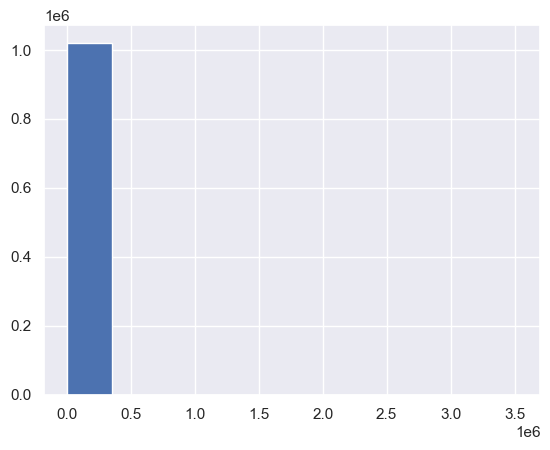

In [19]:
plt.hist(y_train)

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Когда одно из фактических или прогнозируемых значений велико, RMSE > RMSLE. А в нашем случае очень много прогнозируемых значений имеют большую величину**

Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \text{RMSE}\big(\log{(y_i + 1)},\log{(a(x_i) + 1)}\big) = \sqrt{\text{MSE}\big(\log{(y_i + 1)},\log{(a(x_i) + 1)}\big)}$$・ﾟ

У логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашим выборкам колонки `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке:

In [20]:
X_train['log_trip_duration'] = np.log1p(y_train)
X_test['log_trip_duration'] = np.log1p(y_test)
df['log_trip_duration'] = np.log1p(df['trip_duration'])

(array([1.11700e+03, 2.69300e+03, 2.81060e+04, 4.50659e+05, 5.13357e+05,
        2.36540e+04, 8.70000e+01, 1.37300e+03, 0.00000e+00, 4.00000e+00]),
 array([ 0.69314718,  2.13140795,  3.56966872,  5.0079295 ,  6.44619027,
         7.88445104,  9.32271181, 10.76097258, 12.19923336, 13.63749413,
        15.0757549 ]),
 <BarContainer object of 10 artists>)

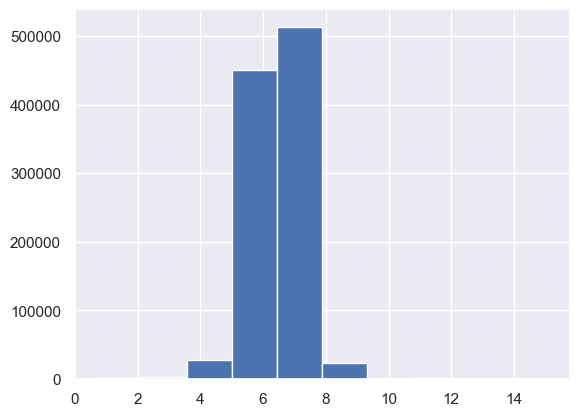

In [21]:
plt.hist(X_train['log_trip_duration'])

## Часть 1. Изучаем `pickup_datetime`

**Задание 2.**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [22]:
X_train.shape

(1021050, 10)

<Axes: xlabel='pickup_datetime', ylabel='count'>

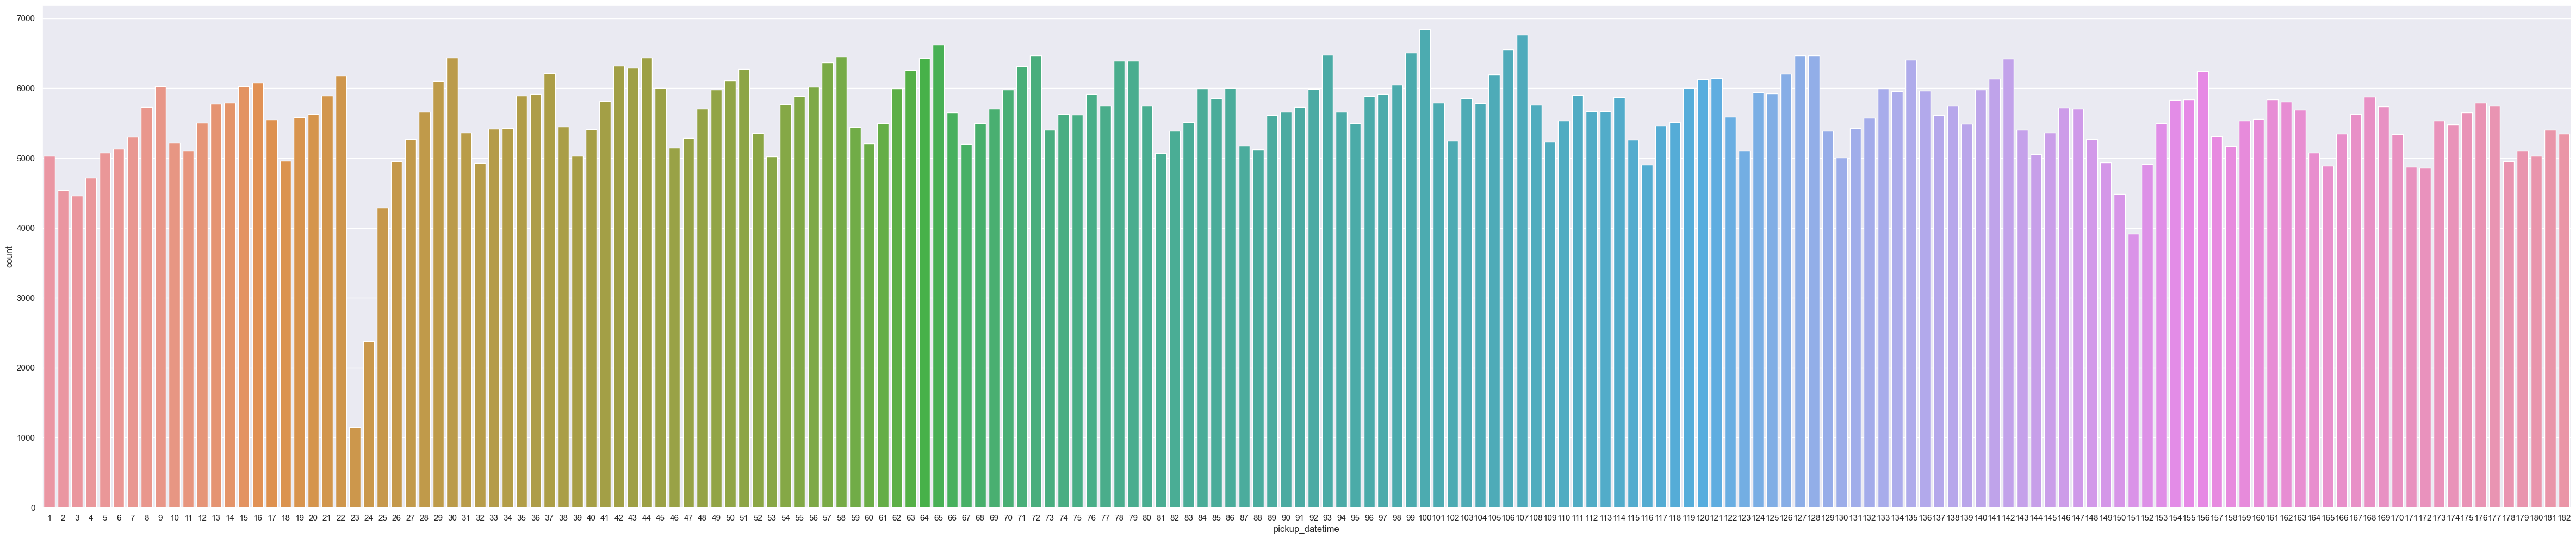

In [23]:
sns.set(rc={'figure.figsize':(60,12)})
sns.countplot(x=X_train.pickup_datetime.dt.dayofyear)

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.
23.01.2016 В Нью-Йорке из-за снежной бури запретили автомобильное движение 
30.05.2016 День поминовения в Нью-Йорке


Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [24]:
X_train.pickup_datetime.dt.dayofyear.value_counts().sort_values(ascending=True)[:10]

23     1154
24     2378
151    3916
25     4296
3      4465
150    4486
2      4541
4      4719
172    4864
171    4875
Name: pickup_datetime, dtype: int64

In [25]:
df1 = X_train.copy()
df1['dayweek'] = X_train.pickup_datetime.dt.dayofweek
temp = pd.DataFrame(df1.groupby(['dayweek']).id.count()).reset_index()

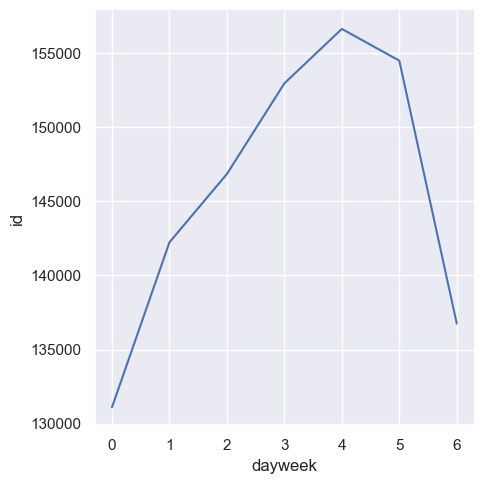

In [26]:
sns.relplot(data=temp, x=temp.dayweek,y=temp.id,kind="line")

In [27]:
df1 = X_train.copy()
df1['hour'] = X_train.pickup_datetime.dt.hour
temp = pd.DataFrame(df1.groupby(['hour']).id.count()).reset_index()

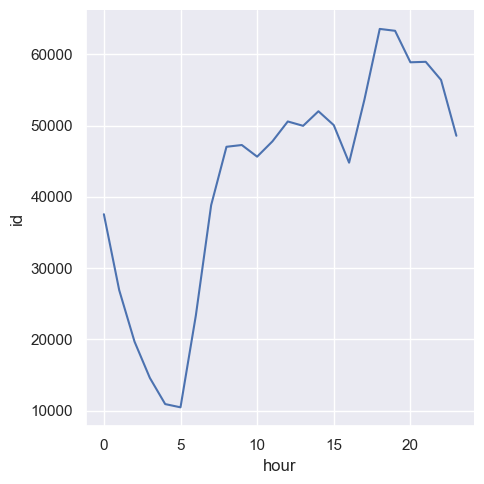

In [28]:
sns.relplot(data=temp, x=temp.hour,y=temp.id,kind="line")

In [29]:
X_train[X_train.pickup_datetime.dt.dayofyear==23].pickup_datetime[:1]

157294   2016-01-23 06:12:40
Name: pickup_datetime, dtype: datetime64[ns]

In [30]:
X_train[X_train.pickup_datetime.dt.dayofyear==151].pickup_datetime[:1]

531304   2016-05-30 17:56:13
Name: pickup_datetime, dtype: datetime64[ns]

**23-24 января 2016 года - Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури**

**30 мая 2016 - День поминовения в Нью-Йорке**

**Задание 3.**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [31]:
X_train.pickup_datetime.dt.month.unique()

array([5, 1, 4, 2, 3, 6], dtype=int64)

In [32]:
X_train.pickup_datetime.dt.hour.unique()

array([ 9, 16, 13, 17, 14,  0, 23, 21, 11, 20, 22, 18, 12,  3, 10, 19,  5,
        8, 15,  1,  2,  7,  6,  4], dtype=int64)

In [33]:
df1 = X_train.copy()
df1['month'] = X_train.pickup_datetime.dt.month
df1['day'] = X_train.pickup_datetime.dt.dayofweek
df1['hour'] = X_train.pickup_datetime.dt.hour
temp = pd.DataFrame(df1.groupby(['month','hour']).id.count()).reset_index()
temp

month  hour    id
0        1     0  5911
1        1     1  4493
2        1     2  3420
3        1     3  2497
4        1     4  1777
..     ...   ...   ...
139      6    19  9970
140      6    20  9056
141      6    21  9612
142      6    22  9368
143      6    23  8351

[144 rows x 3 columns]

In [34]:
temp1 = pd.DataFrame(df1.groupby(['day','hour']).id.count()).reset_index()
temp1

day  hour    id
0      0     0  3050
1      0     1  1772
2      0     2  1159
3      0     3   852
4      0     4   954
..   ...   ...   ...
163    6    19  7062
164    6    20  6412
165    6    21  6119
166    6    22  5561
167    6    23  4438

[168 rows x 3 columns]

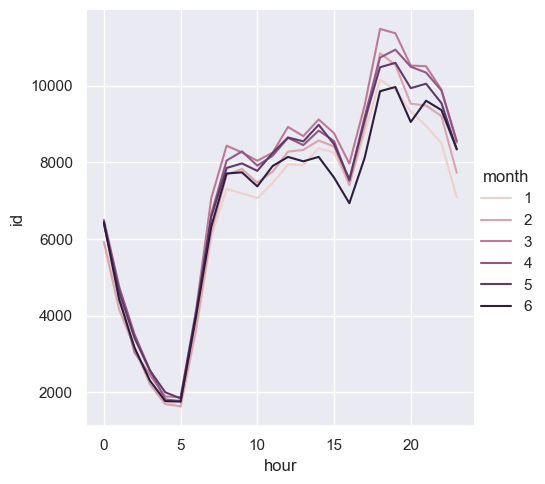

In [35]:
sns.relplot(data=temp, x='hour',y='id',hue='month', kind="line")

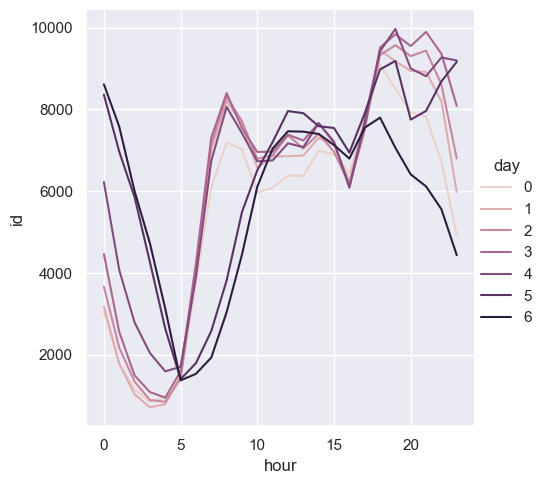

In [36]:
sns.relplot(data=temp1, x='hour',y='id',hue='day', kind="line")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4.**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [37]:
df1 = X_train.copy()
df1['target'] = X_train['log_trip_duration']
df1['day'] = X_train.pickup_datetime.dt.dayofweek
df1['hour'] = X_train.pickup_datetime.dt.hour
df1['day_year'] = X_train.pickup_datetime.dt.dayofyear
temp = pd.DataFrame(df1.groupby(['day']).target.mean()).reset_index()
temp1 = pd.DataFrame(df1.groupby(['hour']).target.mean()).reset_index()
temp2 = pd.DataFrame(df1.groupby(['day_year']).target.mean()).reset_index()

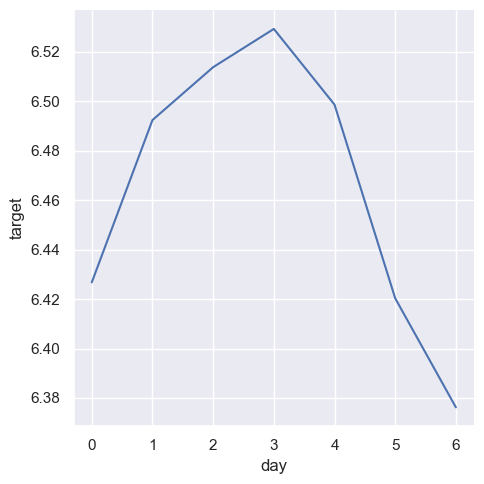

In [38]:
sns.relplot(data=temp, x="day", y="target", kind="line")

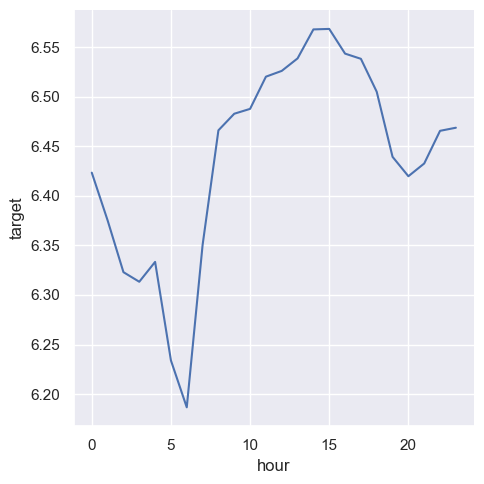

In [39]:
sns.relplot(data=temp1, x="hour", y="target", kind="line")

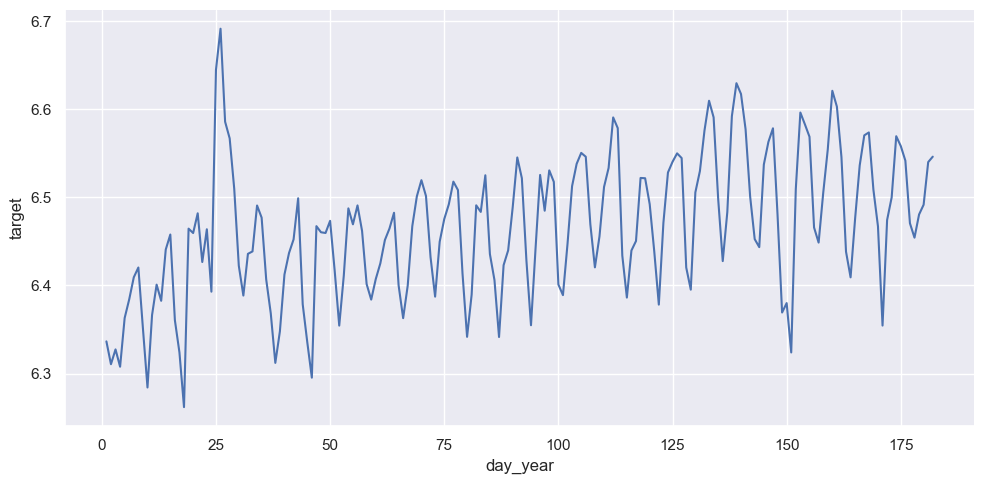

In [40]:
sns.relplot(data=temp2, x="day_year", y="target", kind="line", height=5, aspect=24/12)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [41]:
def get_binary(x):
    if ((x==23) or (x==24) or (x==151)): return "1"
    else: return "0"

X_train['day_week'] = X_train.pickup_datetime.dt.dayofweek
X_train['month'] = X_train.pickup_datetime.dt.month
X_train['hour'] = X_train.pickup_datetime.dt.hour
X_train['day_year'] = X_train.pickup_datetime.dt.dayofyear
X_train['anomal'] = X_train['day_year'].apply(get_binary)

X_test['day_week'] = X_test.pickup_datetime.dt.dayofweek
X_test['month'] = X_test.pickup_datetime.dt.month
X_test['hour'] = X_test.pickup_datetime.dt.hour
X_test['day_year'] = X_test.pickup_datetime.dt.dayofyear
X_test['anomal'] = X_test['day_year'].apply(get_binary)

df['day_week'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month
df['hour'] = df.pickup_datetime.dt.hour
df['day_year'] = df.pickup_datetime.dt.dayofyear
df['anomal'] = df['day_year'].apply(get_binary)


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5.**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [42]:
X_train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
log_trip_duration            float64
day_week                       int64
month                          int64
hour                           int64
day_year                       int64
anomal                        object
dtype: object

In [43]:
X_train.head()

id  vendor_id     pickup_datetime  passenger_count  \
1011257  id2209155          2 2016-05-03 09:03:08                2   
178550   id0586605          1 2016-01-01 16:40:51                1   
551460   id0467144          1 2016-04-24 13:57:03                1   
1434271  id0989010          2 2016-01-10 17:03:47                1   
1173610  id0580742          1 2016-02-25 17:37:36                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1011257        -73.979813        40.752529         -73.982681   
178550         -73.977623        40.746296         -73.968414   
551460         -73.950699        40.779404         -73.863129   
1434271        -73.984558        40.721802         -73.976753   
1173610        -73.967720        40.768742         -73.977173   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  day_week  \
1011257         40.763680                  N           6.739337         1   
178550          40.788933                  N           6.909753         4   
551460          40.768608                  N           6.955593         6   
1434271         40.752213                  N           6.665684         6   
1173610         40.789875                  N           6.597146         3   

         month  hour  day_year anomal  
1011257      5     9       124      0  
178550       1    16         1      0  
551460       4    13       115      0  
1434271      1    17        10      0  
1173610      2    17        56      0

In [44]:
X_Ridge = X_train[['day_week','month','hour','day_year','anomal']]
X_Ridge_test = X_test[['day_week','month','hour','day_year','anomal']]
numeric_data = X_Ridge.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical = list(X_Ridge.dtypes[X_Ridge.dtypes == "object"].index)
X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\3558723533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\3558723533.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")


In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [46]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [47]:
model = pipeline.fit(X_Ridge,
                     X_train['log_trip_duration'])
y_pred = model.predict(X_Ridge_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.7933
Test RMSLE = 0.1128


In [48]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 3209.9767
Test RMSLE = 0.7933


## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Подготовлена функция, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [49]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [50]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [51]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[40.74926221466065, -73.97386327362061], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [52]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Map(center=[40.75228782272339, -73.97237479400634], controls=(ZoomControl(options=['position', 'zoom_in_text',…

**Вопрос**: Какие две точки выделяются на карте?

**Точки аэропортов**

**Задание 6.**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [53]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'day_week', 'month', 'hour', 'day_year', 'anomal'],
      dtype='object')

In [54]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = np.radians(lon1),np.radians(lat1),np.radians(lon2),np.radians(lat2)
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(np.divide(dlat, 2))**2 + np.cos(lat1) * np.cos(lat2) * np.sin(np.divide(dlon, 2))**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r
df['haversine'] = haversine(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)
X_train['haversine'] = haversine(X_train.pickup_longitude, X_train.pickup_latitude, X_train.dropoff_longitude, X_train.dropoff_latitude)
X_test['haversine'] = haversine(X_test.pickup_longitude, X_test.pickup_latitude, X_test.dropoff_longitude, X_test.dropoff_latitude)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [55]:
df['log_haversine'] = np.log(df['haversine'])
X_train['log_haversine'] = np.log(X_train['haversine'])
X_test['log_haversine'] = np.log(X_test['haversine'])
X_train.head()

C:\Users\Egor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Egor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Egor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


id  vendor_id     pickup_datetime  passenger_count  \
1011257  id2209155          2 2016-05-03 09:03:08                2   
178550   id0586605          1 2016-01-01 16:40:51                1   
551460   id0467144          1 2016-04-24 13:57:03                1   
1434271  id0989010          2 2016-01-10 17:03:47                1   
1173610  id0580742          1 2016-02-25 17:37:36                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1011257        -73.979813        40.752529         -73.982681   
178550         -73.977623        40.746296         -73.968414   
551460         -73.950699        40.779404         -73.863129   
1434271        -73.984558        40.721802         -73.976753   
1173610        -73.967720        40.768742         -73.977173   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  day_week  \
1011257         40.763680                  N           6.739337         1   
178550          40.788933                  N           6.909753         4   
551460          40.768608                  N           6.955593         6   
1434271         40.752213                  N           6.665684         6   
1173610         40.789875                  N           6.597146         3   

         month  hour  day_year anomal  haversine  log_haversine  
1011257      5     9       124      0   1.263187       0.233638  
178550       1    16         1      0   4.804012       1.569451  
551460       4    13       115      0   7.471088       2.011041  
1434271      1    17        10      0   3.444869       1.236886  
1173610      2    17        56      0   2.481063       0.908687

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [56]:
X_train[['log_trip_duration','haversine','log_haversine']].corr()[:1]

log_trip_duration  haversine  log_haversine
log_trip_duration                1.0   0.565406       0.772523

**Задание 7.** Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [57]:
X_train['mean_speed']=X_train.haversine/y_train
X_train['mean_speed']

1011257    0.001497
178550     0.004799
551460     0.007129
1434271    0.004394
1173610    0.003389
             ...   
259178     0.004145
1414414    0.002141
131932     0.005765
671155     0.001651
121958     0.007214
Name: mean_speed, Length: 1021050, dtype: float64

<Axes: xlabel='mean_speed', ylabel='Count'>

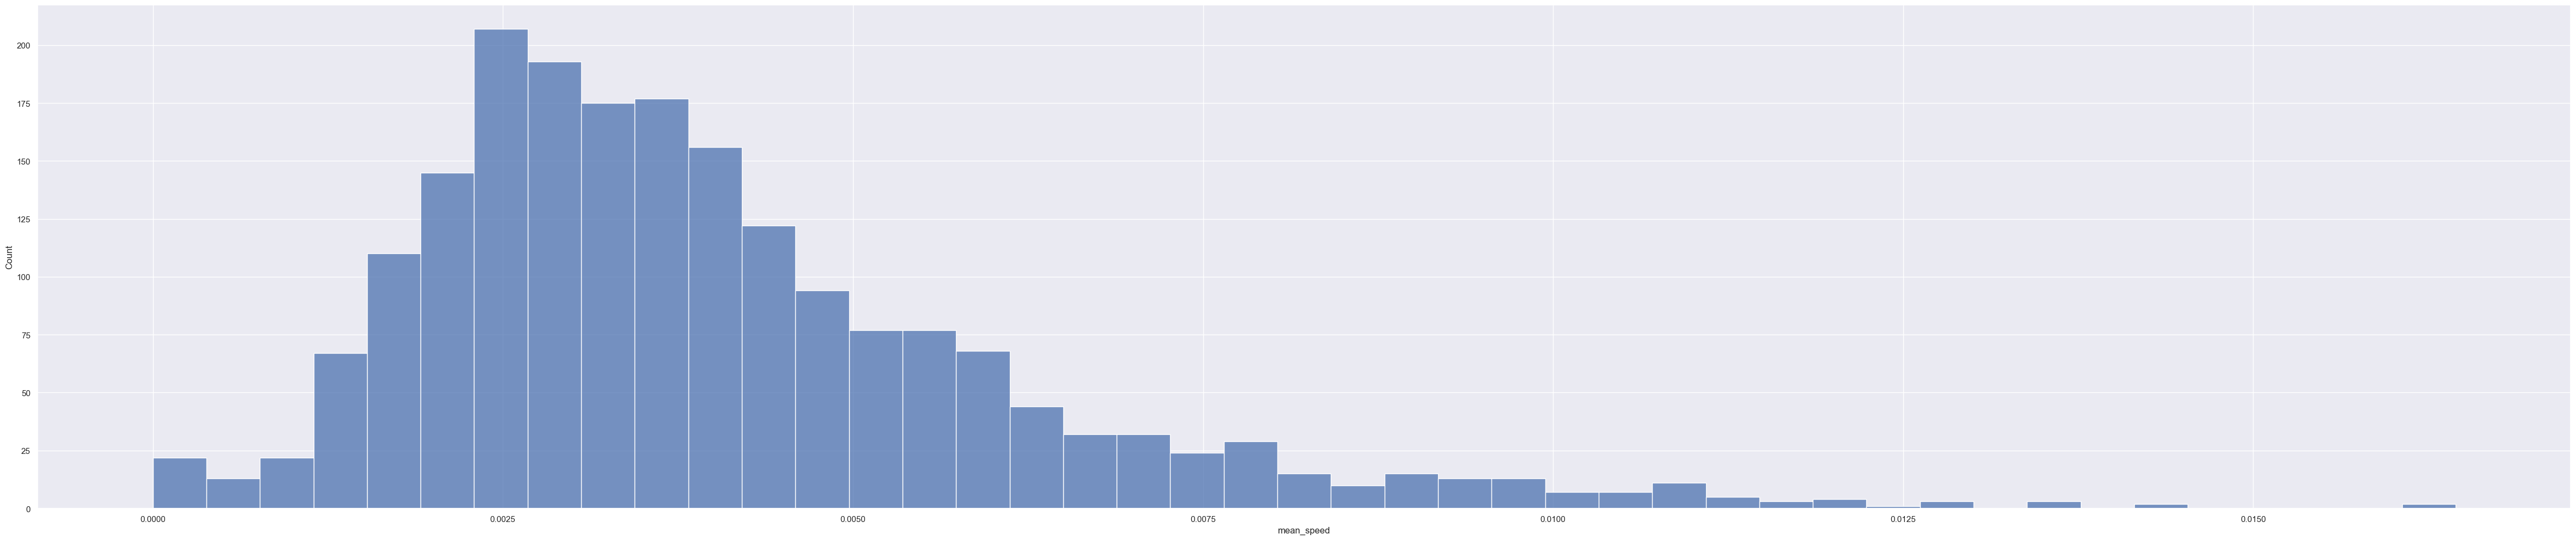

In [58]:
sns.histplot(data=X_train.sample(2000), x=X_train['mean_speed'].sample(2000))

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [59]:
mask = (X_train.mean_speed < np.quantile(X_train.mean_speed, 0.95))
len(X_train[mask])

969997

In [60]:
reg = X_train.mean_speed.quantile(0.05)

In [61]:
otbor = X_train[X_train.mean_speed<reg]
X_train[X_train.mean_speed<reg].shape

(51053, 18)

<Axes: xlabel='mean_speed', ylabel='Count'>

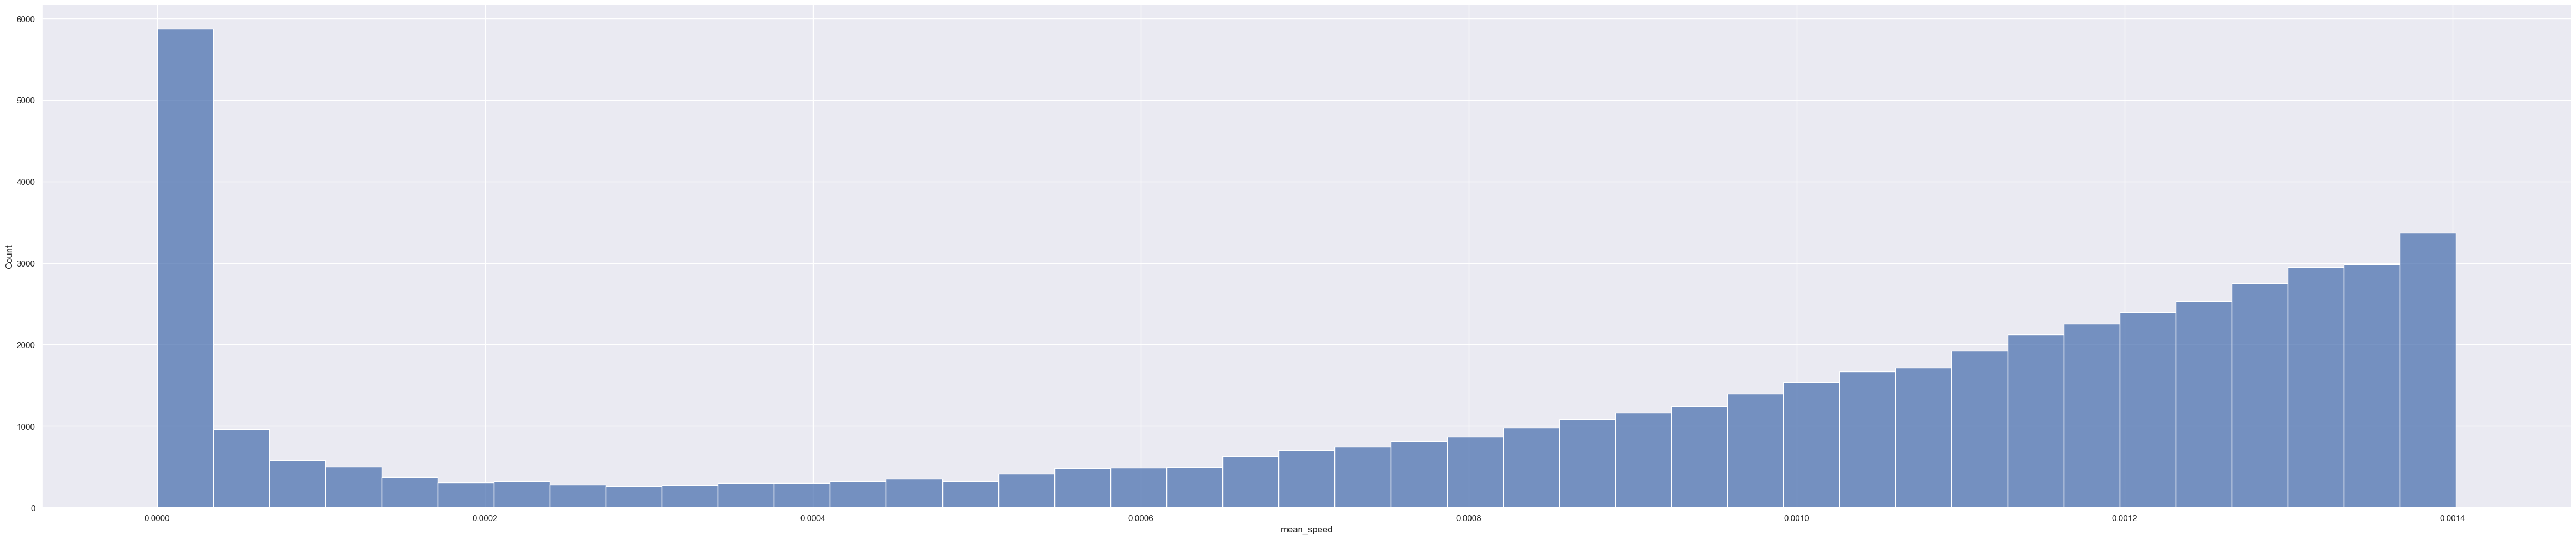

In [62]:
sns.histplot(data=otbor, x='mean_speed')

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [63]:
X_train.head()

id  vendor_id     pickup_datetime  passenger_count  \
1011257  id2209155          2 2016-05-03 09:03:08                2   
178550   id0586605          1 2016-01-01 16:40:51                1   
551460   id0467144          1 2016-04-24 13:57:03                1   
1434271  id0989010          2 2016-01-10 17:03:47                1   
1173610  id0580742          1 2016-02-25 17:37:36                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1011257        -73.979813        40.752529         -73.982681   
178550         -73.977623        40.746296         -73.968414   
551460         -73.950699        40.779404         -73.863129   
1434271        -73.984558        40.721802         -73.976753   
1173610        -73.967720        40.768742         -73.977173   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  day_week  \
1011257         40.763680                  N           6.739337         1   
178550          40.788933                  N           6.909753         4   
551460          40.768608                  N           6.955593         6   
1434271         40.752213                  N           6.665684         6   
1173610         40.789875                  N           6.597146         3   

         month  hour  day_year anomal  haversine  log_haversine  mean_speed  
1011257      5     9       124      0   1.263187       0.233638    0.001497  
178550       1    16         1      0   4.804012       1.569451    0.004799  
551460       4    13       115      0   7.471088       2.011041    0.007129  
1434271      1    17        10      0   3.444869       1.236886    0.004394  
1173610      2    17        56      0   2.481063       0.908687    0.003389

In [64]:
temp = pd.DataFrame(X_train.groupby(['day_week','hour']).mean_speed.median()).reset_index()
temp

day_week  hour  mean_speed
0           0     0    0.005645
1           0     1    0.005594
2           0     2    0.005841
3           0     3    0.005646
4           0     4    0.006727
..        ...   ...         ...
163         6    19    0.003914
164         6    20    0.004253
165         6    21    0.004518
166         6    22    0.004739
167         6    23    0.005139

[168 rows x 3 columns]

In [65]:
viz = temp.pivot("day_week", "hour", "mean_speed")
viz.head()

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\2602993111.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  viz = temp.pivot("day_week", "hour", "mean_speed")


hour            0         1         2         3         4         5   \
day_week                                                               
0         0.005645  0.005594  0.005841  0.005646  0.006727  0.006500   
1         0.005274  0.005490  0.005638  0.006098  0.006373  0.006370   
2         0.004962  0.005415  0.005598  0.005817  0.006368  0.006320   
3         0.004807  0.005258  0.005512  0.005872  0.006247  0.006118   
4         0.004445  0.004800  0.004997  0.005266  0.005820  0.006382   

hour            6         7         8         9   ...        14        15  \
day_week                                          ...                       
0         0.005215  0.004032  0.003199  0.003011  ...  0.003168  0.003213   
1         0.004998  0.003757  0.002899  0.002646  ...  0.002746  0.002775   
2         0.005091  0.003754  0.002922  0.002664  ...  0.002649  0.002682   
3         0.005118  0.003776  0.002889  0.002700  ...  0.002677  0.002706   
4         0.005269  0.003867  0.003008  0.002732  ...  0.002944  0.002868   

hour            16        17        18        19        20        21  \
day_week                                                               
0         0.003334  0.003373  0.003362  0.003818  0.004236  0.004412   
1         0.002980  0.003024  0.003053  0.003470  0.003899  0.004091   
2         0.002912  0.002895  0.002977  0.003275  0.003768  0.004004   
3         0.002920  0.002943  0.002944  0.003218  0.003650  0.003762   
4         0.003056  0.003074  0.003100  0.003239  0.003513  0.003612   

hour            22        23  
day_week                      
0         0.004545  0.004968  
1         0.004326  0.004645  
2         0.004136  0.004462  
3         0.003866  0.004140  
4         0.003659  0.003723  

[5 rows x 24 columns]

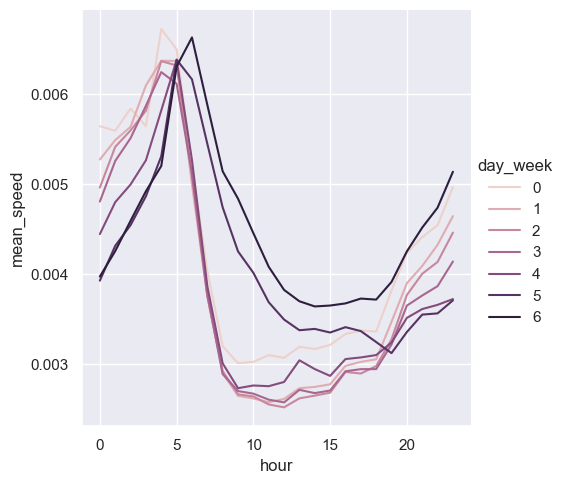

In [66]:
sns.relplot(data=temp, x='hour',y='mean_speed',hue='day_week', kind="line")

<Axes: xlabel='hour', ylabel='day_week'>

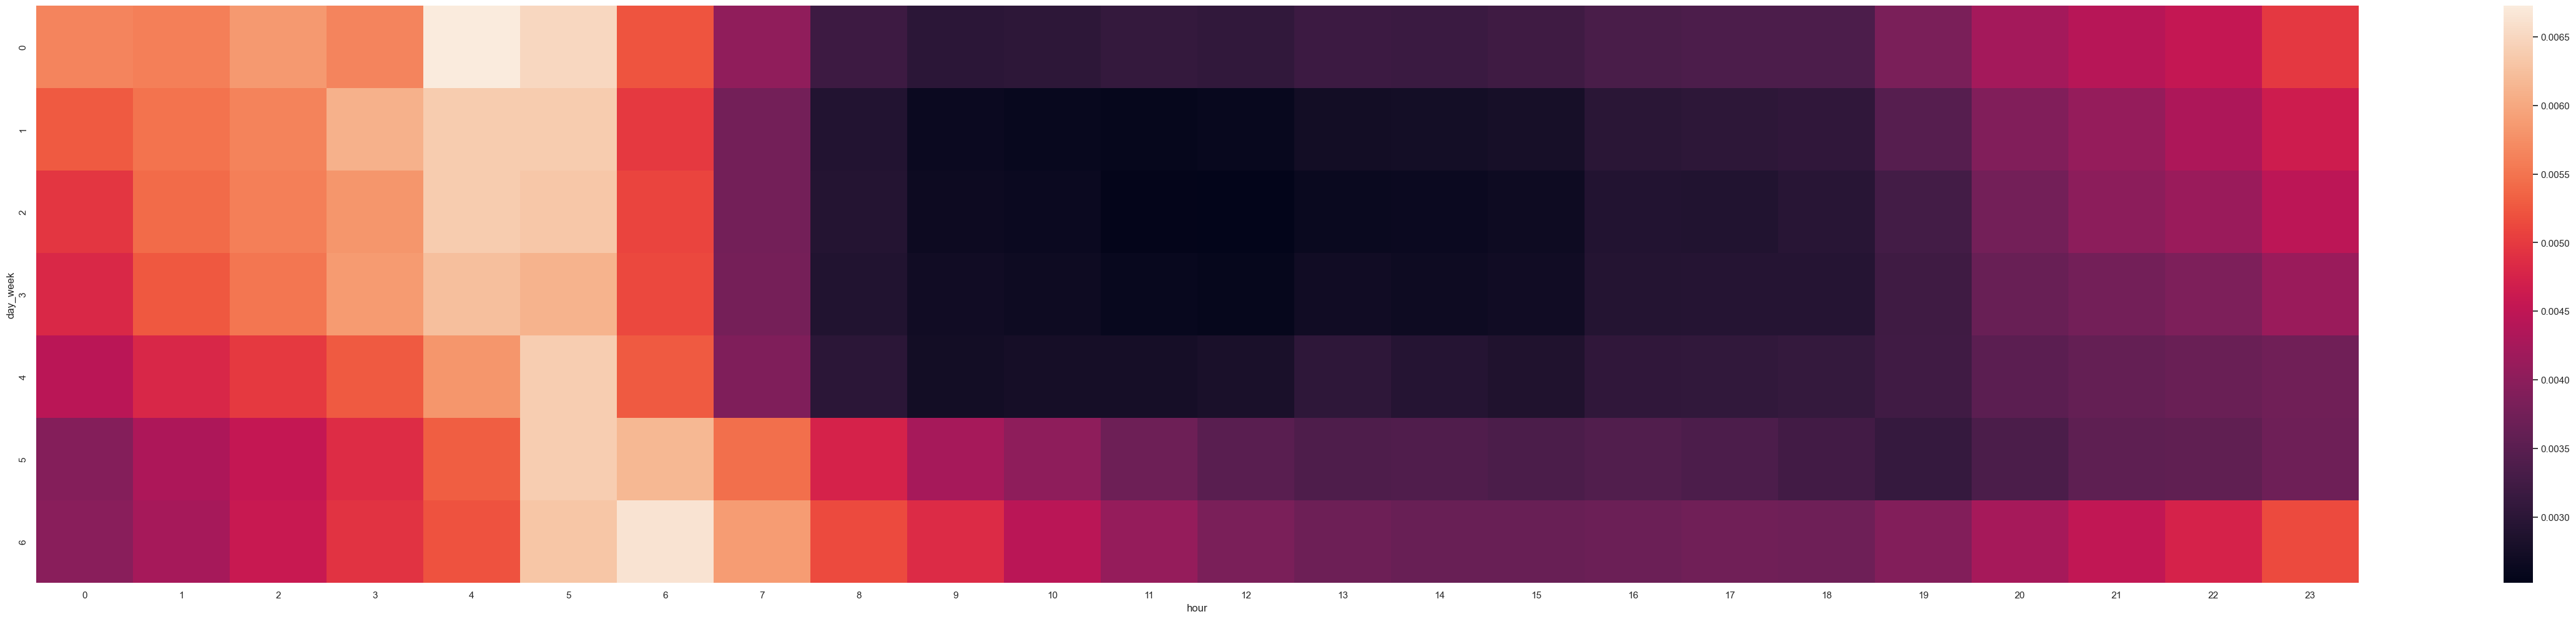

In [67]:
sns.heatmap(viz)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [68]:
X_train = X_train.drop(['mean_speed'], axis=1)

In [69]:
X_train.head()

id  vendor_id     pickup_datetime  passenger_count  \
1011257  id2209155          2 2016-05-03 09:03:08                2   
178550   id0586605          1 2016-01-01 16:40:51                1   
551460   id0467144          1 2016-04-24 13:57:03                1   
1434271  id0989010          2 2016-01-10 17:03:47                1   
1173610  id0580742          1 2016-02-25 17:37:36                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1011257        -73.979813        40.752529         -73.982681   
178550         -73.977623        40.746296         -73.968414   
551460         -73.950699        40.779404         -73.863129   
1434271        -73.984558        40.721802         -73.976753   
1173610        -73.967720        40.768742         -73.977173   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  day_week  \
1011257         40.763680                  N           6.739337         1   
178550          40.788933                  N           6.909753         4   
551460          40.768608                  N           6.955593         6   
1434271         40.752213                  N           6.665684         6   
1173610         40.789875                  N           6.597146         3   

         month  hour  day_year anomal  haversine  log_haversine  
1011257      5     9       124      0   1.263187       0.233638  
178550       1    16         1      0   4.804012       1.569451  
551460       4    13       115      0   7.471088       2.011041  
1434271      1    17        10      0   3.444869       1.236886  
1173610      2    17        56      0   2.481063       0.908687

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [70]:
def get_binary(x):
    if ((x>=9) and (x<=18)): return "1"
    else: return "0"
X_train['probki'] = X_train.pickup_datetime.dt.hour.apply(get_binary)
X_test['probki'] = X_test.pickup_datetime.dt.hour.apply(get_binary)
df['probki'] = df.pickup_datetime.dt.hour.apply(get_binary)

In [71]:
X_train.head()

id  vendor_id     pickup_datetime  passenger_count  \
1011257  id2209155          2 2016-05-03 09:03:08                2   
178550   id0586605          1 2016-01-01 16:40:51                1   
551460   id0467144          1 2016-04-24 13:57:03                1   
1434271  id0989010          2 2016-01-10 17:03:47                1   
1173610  id0580742          1 2016-02-25 17:37:36                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1011257        -73.979813        40.752529         -73.982681   
178550         -73.977623        40.746296         -73.968414   
551460         -73.950699        40.779404         -73.863129   
1434271        -73.984558        40.721802         -73.976753   
1173610        -73.967720        40.768742         -73.977173   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  day_week  \
1011257         40.763680                  N           6.739337         1   
178550          40.788933                  N           6.909753         4   
551460          40.768608                  N           6.955593         6   
1434271         40.752213                  N           6.665684         6   
1173610         40.789875                  N           6.597146         3   

         month  hour  day_year anomal  haversine  log_haversine probki  
1011257      5     9       124      0   1.263187       0.233638      1  
178550       1    16         1      0   4.804012       1.569451      1  
551460       4    13       115      0   7.471088       2.011041      1  
1434271      1    17        10      0   3.444869       1.236886      1  
1173610      2    17        56      0   2.481063       0.908687      1

**Задание 8.** Как уже было замечено выше, на карте выделяются две точки - аэропорты La Guardia и John F Kennedy. Для каждого из аэропортов добавьте в выборки два признака: началась ли поездка из этого аэропорта и закончилась ли поездка в этом аэропорте.

In [72]:
X_train["Aeroport_Kennedy_start"] = "0"
X_train.loc[((X_train.pickup_longitude<=-73.78) & (X_train.pickup_longitude>=-73.783)) & ((X_train.pickup_latitude>=40.64) & (X_train.pickup_latitude<=40.645)),"Aeroport_Kennedy_start"]="1"
X_train["Aeroport_Kennedy_end"] = "0"
X_train.loc[((X_train.dropoff_longitude<=-73.78) & (X_train.dropoff_longitude>=-73.783)) & ((X_train.dropoff_latitude>=40.64) & (X_train.dropoff_latitude<=40.645)),"Aeroport_Kennedy_end"]="1"

X_train["Aeroport_Guardia_start"] = "0"
X_train.loc[((X_train.pickup_longitude<=-73.865) & (X_train.pickup_longitude>=-73.88)) & ((X_train.pickup_latitude>=40.78) & (X_train.pickup_latitude<=40.788)),"Aeroport_Guardia_start"]="1"
X_train["Aeroport_Guardia_end"] = "0"
X_train.loc[((X_train.dropoff_longitude<=-73.865) & (X_train.dropoff_longitude>=-73.88)) & ((X_train.dropoff_latitude>=40.78) & (X_train.dropoff_latitude<=40.788)),"Aeroport_Guardia_end"]="1"

X_test["Aeroport_Kennedy_start"] = "0"
X_test.loc[((X_test.pickup_longitude<=-73.78) & (X_test.pickup_longitude>=-73.783)) & ((X_test.pickup_latitude>=40.64) & (X_test.pickup_latitude<=40.645)),"Aeroport_Kennedy_start"]="1"
X_test["Aeroport_Kennedy_end"] = "0"
X_test.loc[((X_test.dropoff_longitude<=-73.78) & (X_test.dropoff_longitude>=-73.783)) & ((X_test.dropoff_latitude>=40.64) & (X_test.dropoff_latitude<=40.645)),"Aeroport_Kennedy_end"]="1"

X_test["Aeroport_Guardia_start"] = "0"
X_test.loc[((X_test.pickup_longitude<=-73.865) & (X_test.pickup_longitude>=-73.88)) & ((X_test.pickup_latitude>=40.78) & (X_test.pickup_latitude<=40.788)),"Aeroport_Guardia_start"]="1"
X_test["Aeroport_Guardia_end"] = "0"
X_test.loc[((X_test.dropoff_longitude<=-73.865) & (X_test.dropoff_longitude>=-73.88)) & ((X_test.dropoff_latitude>=40.78) & (X_test.dropoff_latitude<=40.788)),"Aeroport_Guardia_end"]="1"

df["Aeroport_Kennedy_start"] = "0"
df.loc[((df.pickup_longitude<=-73.78) & (df.pickup_longitude>=-73.783)) & ((df.pickup_latitude>=40.64) & (df.pickup_latitude<=40.645)),"Aeroport_Kennedy_start"]="1"
df["Aeroport_Kennedy_end"] = "0"
df.loc[((df.dropoff_longitude<=-73.78) & (df.dropoff_longitude>=-73.783)) & ((df.dropoff_latitude>=40.64) & (df.dropoff_latitude<=40.645)),"Aeroport_Kennedy_end"]="1"

df["Aeroport_Guardia_start"] = "0"
df.loc[((df.pickup_longitude<=-73.865) & (df.pickup_longitude>=-73.88)) & ((df.pickup_latitude>=40.78) & (df.pickup_latitude<=40.788)),"Aeroport_Guardia_start"]="1"
df["Aeroport_Guardia_end"] = "0"
df.loc[((df.dropoff_longitude<=-73.865) & (df.dropoff_longitude>=-73.88)) & ((df.dropoff_latitude>=40.78) & (df.dropoff_latitude<=40.788)),"Aeroport_Guardia_end"]="1"

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

<Axes: xlabel='log_trip_duration', ylabel='probki'>

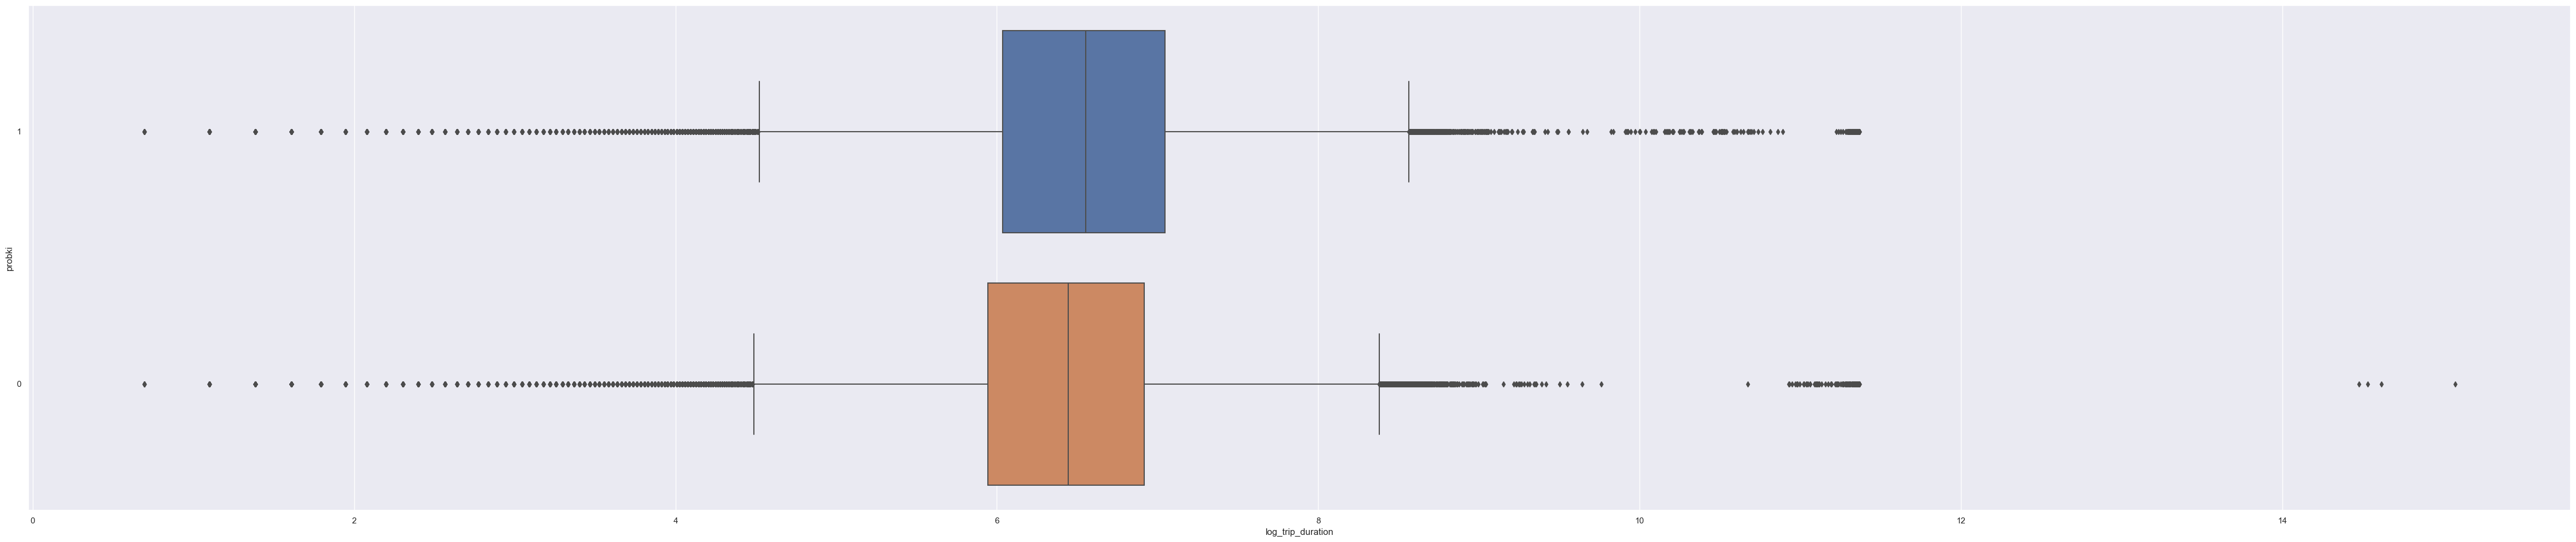

In [73]:
sns.boxplot(data=X_train, x="log_trip_duration", y="probki")

<Axes: xlabel='log_trip_duration', ylabel='Aeroport_Kennedy_start'>

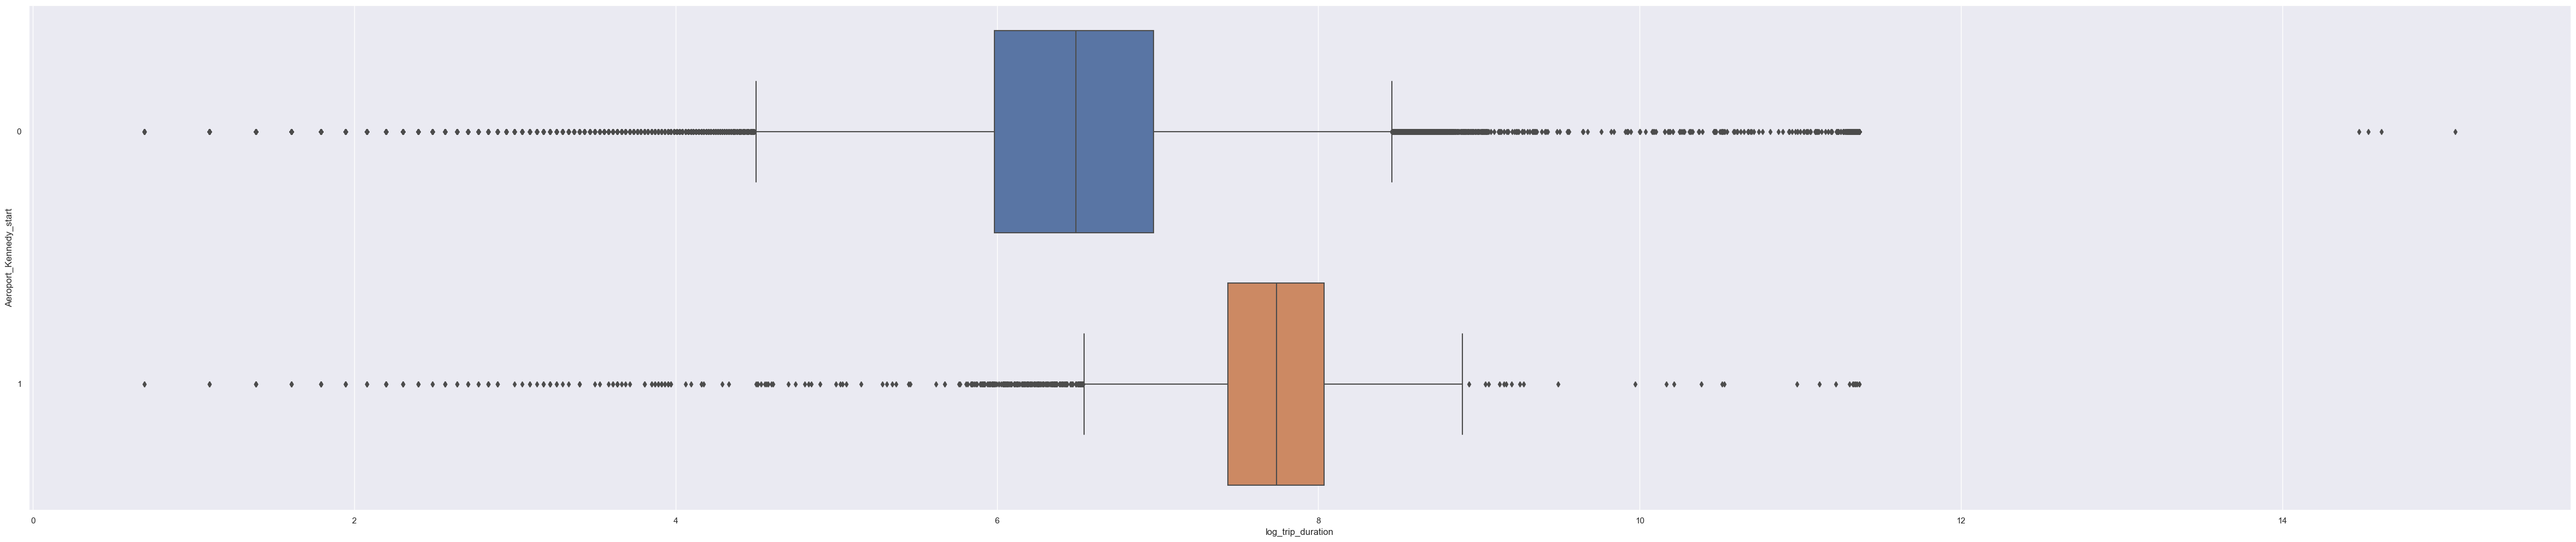

In [74]:
sns.boxplot(data=X_train, x="log_trip_duration", y="Aeroport_Kennedy_start")

<Axes: xlabel='log_trip_duration', ylabel='Aeroport_Guardia_start'>

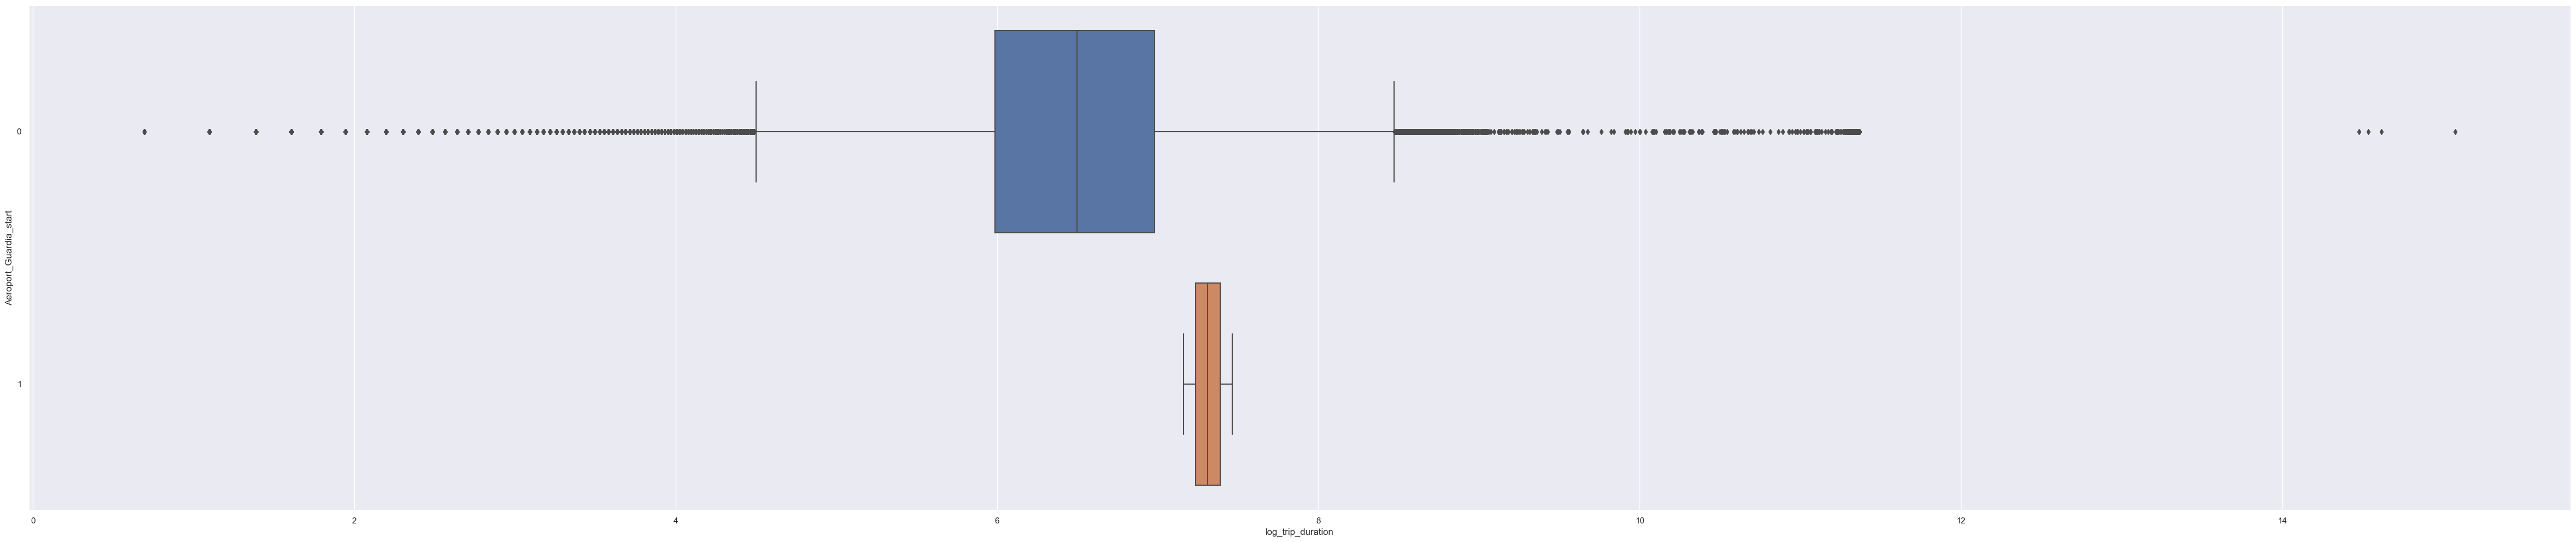

In [75]:
sns.boxplot(data=X_train, x="log_trip_duration", y="Aeroport_Guardia_start")

<Axes: xlabel='log_trip_duration', ylabel='Aeroport_Guardia_end'>

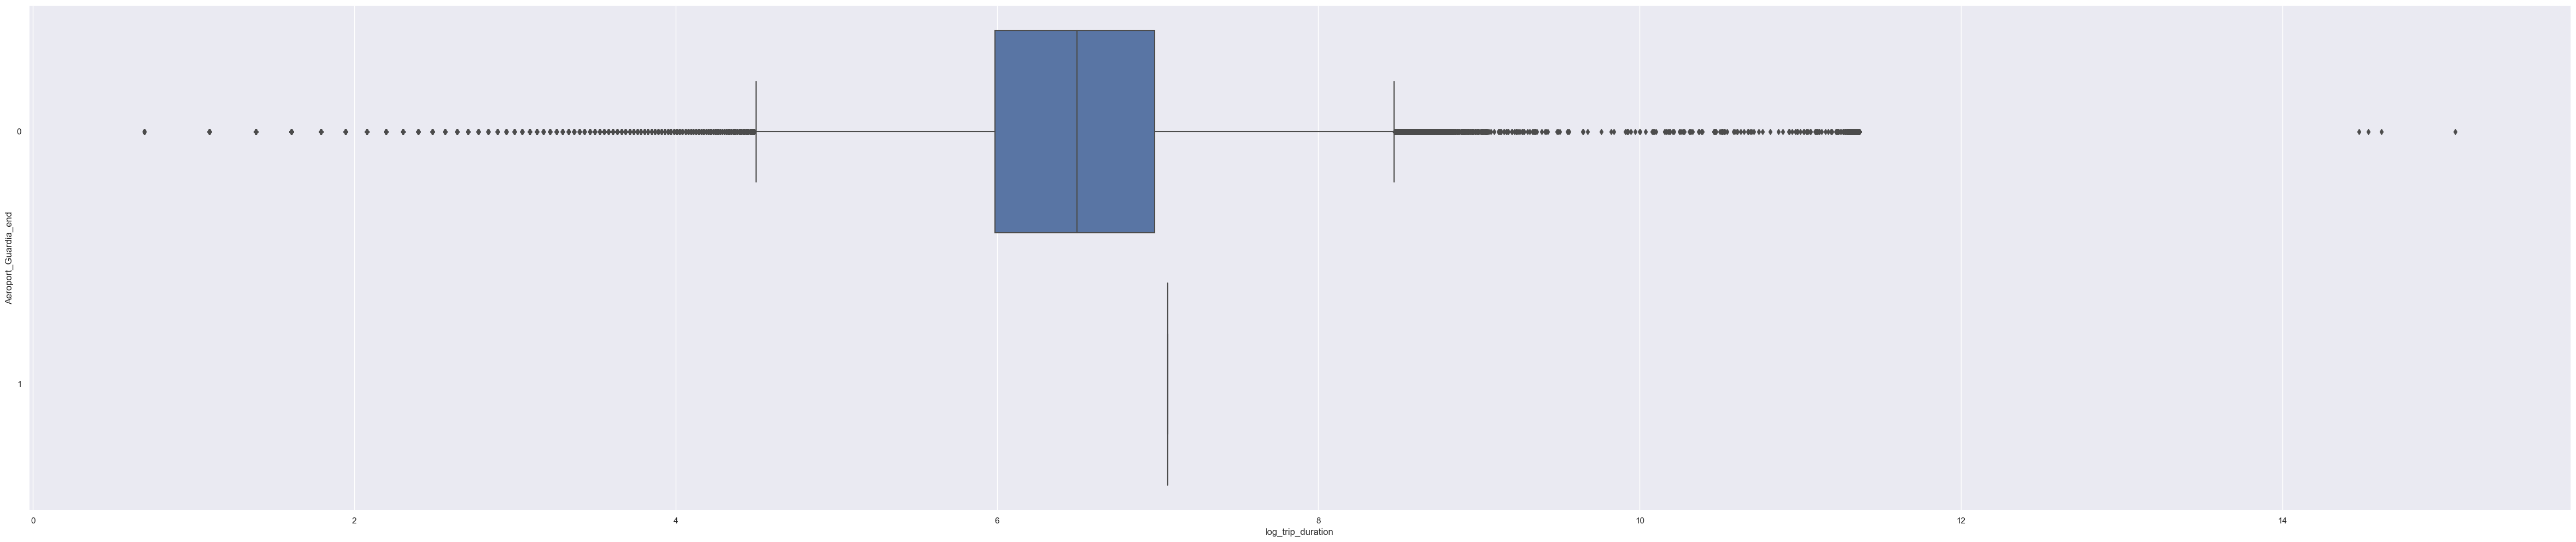

In [76]:
sns.boxplot(data=X_train, x="log_trip_duration", y="Aeroport_Guardia_end")

<Axes: xlabel='log_trip_duration', ylabel='Aeroport_Kennedy_end'>

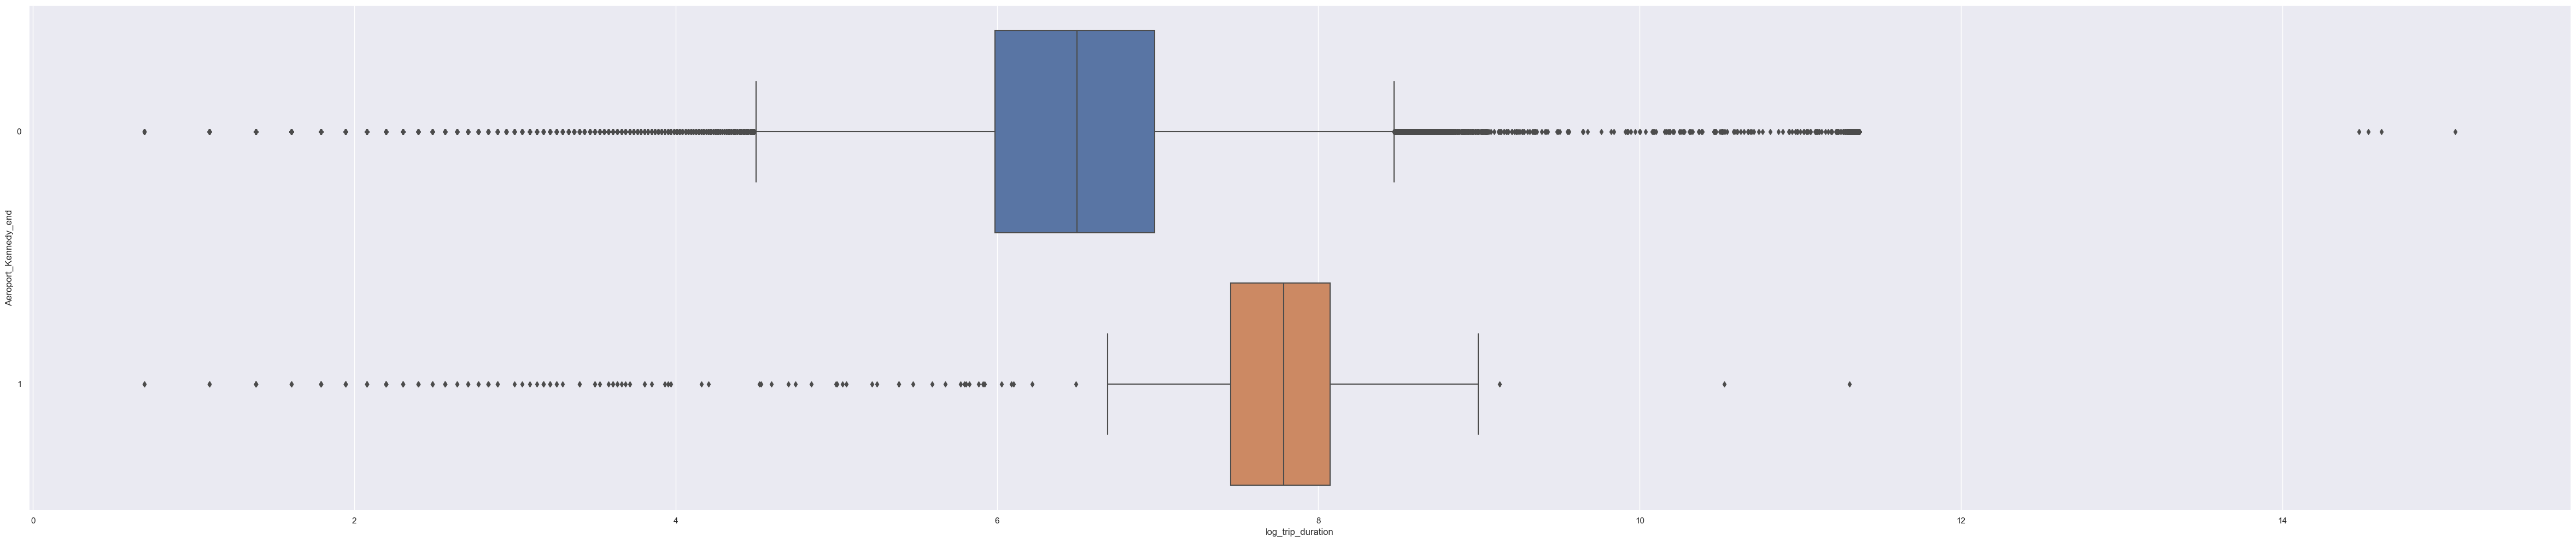

In [77]:
sns.boxplot(data=X_train, x="log_trip_duration", y="Aeroport_Kennedy_end")

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9.** Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [78]:
# Импорт базового класса для создания пользовательских трансформеров в scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin

# Импорт функции для вычисления расстояний между точками
from scipy.spatial.distance import cdist

# Определение словаря для имен колонок с географическими координатами
COL_NAMES = dict(
    pick_lat="pickup_latitude",  # Широта точки отправления
    pick_lon="pickup_longitude", # Долгота точки отправления
    drop_lat="dropoff_latitude", # Широта точки назначения
    drop_lon="dropoff_longitude" # Долгота точки назначения
)

# Определение пользовательского трансформера для работы с географической сеткой
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loc, col, row, col_names=COL_NAMES):
        """
        Конструктор класса.
        Параметры:
        - loc: массив с координатами всех локаций
        - col: количество столбцов в сетке
        - row: количество строк в сетке
        - col_names: словарь с именами колонок (по умолчанию COL_NAMES)
        """
        self.location_mh = loc  # Координаты всех локаций
        self.col = col  # Количество столбцов
        self.row = row  # Количество строк
        self.col_names = col_names  # Имена колонок
        # Извлечение названий колонок из словаря
        self.pick_lat = col_names["pick_lat"]
        self.pick_lon = col_names["pick_lon"]
        self.drop_lat = col_names["drop_lat"]
        self.drop_lon = col_names["drop_lon"]
        # Вычисление минимальных и максимальных значений широты и долготы
        self.lat_min, self.lat_max = loc[:, 0].min(), loc[:, 0].max()
        self.lon_min, self.lon_max = loc[:, 1].min(), loc[:, 1].max()

    def _fit(self):
        """
        Создание параметров сетки.
        Вычисляет размеры ячеек сетки и центральные координаты каждой ячейки.
        """
        # Размеры одной ячейки сетки по широте и долготе
        self.walls = [
            (self.location_mh[:, 0].max() - self.location_mh[:, 0].min()) / self.col,  # Высота ячейки
            (self.location_mh[:, 1].max() - self.location_mh[:, 1].min()) / self.row   # Ширина ячейки
        ]

        # Центральные координаты каждой ячейки
        self.circles_loc = np.array([
            (
                (self.location_mh[:, 0].min() + i * (self.walls[0] / 2)),
                (self.location_mh[:, 1].min() + j * (self.walls[1] / 2))
            )
            for i in range(1, self.col * 2, 2)  # Проход по столбцам
            for j in range(1, self.row * 2, 2)  # Проход по строкам
        ])

        return self.walls, self.circles_loc

    def get_sector_idx(self, X):
        """
        Определение индексов ячеек для точек отправления и назначения.
        Параметры:
        - X: датафрейм с координатами
        Возвращает:
        - pickup_idx: индексы ячеек для точек отправления
        - dropoff_idx: индексы ячеек для точек назначения
        """
        # Вычисление индексов ближайших ячеек для точек отправления
        pickup_idx = cdist(
            X.loc[:, [self.pick_lat, self.pick_lon]],  # Координаты отправления
            self.circles_loc  # Координаты ячеек
        ).argmin(axis=1)

        # Вычисление индексов ближайших ячеек для точек назначения
        dropoff_idx = cdist(
            X.loc[:, [self.drop_lat, self.drop_lon]],  # Координаты назначения
            self.circles_loc  # Координаты ячеек
        ).argmin(axis=1)

        # Проверка валидности точек отправления (в пределах заданных границ)
        qry = f"@self.lat_min <= {self.pick_lat} <= @self.lat_max and @self.lon_min <= {self.pick_lon} <= @self.lon_max"
        pickup_valid = X.eval(qry).to_numpy()
        pickup_idx[~pickup_valid] = -1  # Установка -1 для невалидных точек

        # Проверка валидности точек назначения (в пределах заданных границ)
        qry = f"@self.lat_min <= {self.drop_lat} <= @self.lat_max and @self.lon_min <= {self.drop_lon} <= @self.lon_max"
        dropoff_valid = X.eval(qry).to_numpy()
        dropoff_idx[~dropoff_valid] = -1  # Установка -1 для невалидных точек

        return pickup_idx, dropoff_idx

    def transform(self, X):
        """
        Преобразование датафрейма: добавление индексов ячеек для каждой точки.
        """
        _, self.circles_loc = self._fit()  # Построение сетки
        return (X,) + self.get_sector_idx(X)  # Возврат данных с добавлением индексов


In [79]:
mh = np.array([
              [40.703314, -74.018608],
              [40.703314, -73.934241],
              [40.791438, -73.934241],
              [40.791438, -74.018608]
               ])

a = MapGridTransformer(mh, 5, 4)

In [80]:
df_temp = a.transform(X_train)
df_temp1 = a.transform(X_test)
df_temp2 = a.transform(df)

In [81]:
X_train["start"]=df_temp[-2]
X_train["end"]=df_temp[-1]

X_test["start"]=df_temp1[-2]
X_test["end"]=df_temp1[-1]

df["start"]=df_temp2[-2]
df["end"]=df_temp2[-1]

In [82]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
df = df.reset_index()
X_train.head()

index         id  vendor_id     pickup_datetime  passenger_count  \
0  1011257  id2209155          2 2016-05-03 09:03:08                2   
1   178550  id0586605          1 2016-01-01 16:40:51                1   
2   551460  id0467144          1 2016-04-24 13:57:03                1   
3  1434271  id0989010          2 2016-01-10 17:03:47                1   
4  1173610  id0580742          1 2016-02-25 17:37:36                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.979813        40.752529         -73.982681         40.763680   
1        -73.977623        40.746296         -73.968414         40.788933   
2        -73.950699        40.779404         -73.863129         40.768608   
3        -73.984558        40.721802         -73.976753         40.752213   
4        -73.967720        40.768742         -73.977173         40.789875   

  store_and_fwd_flag  ...  anomal  haversine  log_haversine  probki  \
0                  N  ...       0   1.263187       0.233638       1   
1                  N  ...       0   4.804012       1.569451       1   
2                  N  ...       0   7.471088       2.011041       1   
3                  N  ...       0   3.444869       1.236886       1   
4                  N  ...       0   2.481063       0.908687       1   

   Aeroport_Kennedy_start Aeroport_Kennedy_end  Aeroport_Guardia_start  \
0                       0                    0                       0   
1                       0                    0                       0   
2                       0                    0                       0   
3                       0                    0                       0   
4                       0                    0                       0   

   Aeroport_Guardia_end start end  
0                     0     9  13  
1                     0     9  18  
2                     0    19  -1  
3                     0     5   9  
4                     0    14  17  

[5 rows x 25 columns]

**Задание 10.** Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, численные признаки отмасштабируйте.

In [83]:
X_train.describe()

index     vendor_id  passenger_count  pickup_longitude  \
count  1.021050e+06  1.021050e+06     1.021050e+06      1.021050e+06   
mean   7.290623e+05  1.535298e+00     1.663364e+00     -7.397347e+01   
std    4.211426e+05  4.987527e-01     1.312695e+00      6.453953e-02   
min    0.000000e+00  1.000000e+00     0.000000e+00     -1.219332e+02   
25%    3.639772e+05  1.000000e+00     1.000000e+00     -7.399187e+01   
50%    7.292915e+05  2.000000e+00     1.000000e+00     -7.398175e+01   
75%    1.093811e+06  2.000000e+00     2.000000e+00     -7.396734e+01   
max    1.458643e+06  2.000000e+00     9.000000e+00     -6.133553e+01   

       pickup_latitude  dropoff_longitude  dropoff_latitude  \
count     1.021050e+06       1.021050e+06      1.021050e+06   
mean      4.075093e+01      -7.397339e+01      4.075180e+01   
std       3.347413e-02       6.416123e-02      3.581601e-02   
min       3.435970e+01      -1.219332e+02      3.218114e+01   
25%       4.073734e+01      -7.399132e+01      4.073587e+01   
50%       4.075410e+01      -7.397975e+01      4.075453e+01   
75%       4.076834e+01      -7.396303e+01      4.076981e+01   
max       5.188108e+01      -6.133553e+01      4.392103e+01   

       log_trip_duration      day_week         month          hour  \
count       1.021050e+06  1.021050e+06  1.021050e+06  1.021050e+06   
mean        6.467067e+00  3.050223e+00  3.516109e+00  1.360399e+01   
std         7.960733e-01  1.954022e+00  1.681166e+00  6.402083e+00   
min         6.931472e-01  0.000000e+00  1.000000e+00  0.000000e+00   
25%         5.986452e+00  1.000000e+00  2.000000e+00  9.000000e+00   
50%         6.498282e+00  3.000000e+00  4.000000e+00  1.400000e+01   
75%         6.981006e+00  5.000000e+00  5.000000e+00  1.900000e+01   
max         1.507575e+01  6.000000e+00  6.000000e+00  2.300000e+01   

           day_year     haversine  log_haversine         start           end  
count  1.021050e+06  1.021050e+06   1.021050e+06  1.021050e+06  1.021050e+06  
mean   9.182435e+01  3.443973e+00           -inf  9.005404e+00  8.526689e+00  
std    5.157072e+01  4.361104e+00            NaN  5.948553e+00  6.309502e+00  
min    1.000000e+00  0.000000e+00           -inf -1.000000e+00 -1.000000e+00  
25%    4.800000e+01  1.231736e+00   2.084245e-01  5.000000e+00  4.000000e+00  
50%    9.200000e+01  2.095418e+00   7.397533e-01  9.000000e+00  9.000000e+00  
75%    1.360000e+02  3.879408e+00   1.355683e+00  1.400000e+01  1.400000e+01  
max    1.820000e+02  1.240909e+03   7.123599e+00  1.900000e+01  1.900000e+01

In [84]:
X_train = X_train[~X_train.isin([np.nan, np.inf, -np.inf]).any(1)]
X_test = X_test[~X_test.isin([np.nan, np.inf, -np.inf]).any(1)]
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\1776576186.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  X_train = X_train[~X_train.isin([np.nan, np.inf, -np.inf]).any(1)]
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\1776576186.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  X_test = X_test[~X_test.isin([np.nan, np.inf, -np.inf]).any(1)]
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\1776576186.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]


In [85]:
X = df.drop(columns=["trip_duration"])
y = df['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)

In [86]:
X_Ridge = X_train[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end',
                   'log_haversine','start','end']]
X_Ridge_test = X_test[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end',
                   'log_haversine','start','end']]
numeric_data = X_Ridge.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical = list(X_Ridge.dtypes[X_Ridge.dtypes == "object"].index)
X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\3953688007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\3953688007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")


In [87]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [88]:
model = pipeline.fit(X_Ridge,
                     X_train['log_trip_duration'])
y_pred = model.predict(X_Ridge_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4810
Test RMSLE = 0.0691


In [89]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 4395.6451
Test RMSLE = 0.4810


## Часть 3. Изучаем оставшиеся признаки

**Задание 11.** У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [90]:
X_train['vendor_id'].nunique()

2

In [91]:
X_train['passenger_count'].nunique()

9

In [92]:
X_train['passenger_count'] = X_train['passenger_count'].astype("str")
X_test['passenger_count'] = X_test['passenger_count'].astype("str")
X_train['vendor_id'] = X_train['vendor_id'].astype("str")
X_test['vendor_id'] = X_test['vendor_id'].astype("str")

In [93]:
X_train['store_and_fwd_flag'].nunique()

2

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<Axes: xlabel='log_trip_duration', ylabel='vendor_id'>

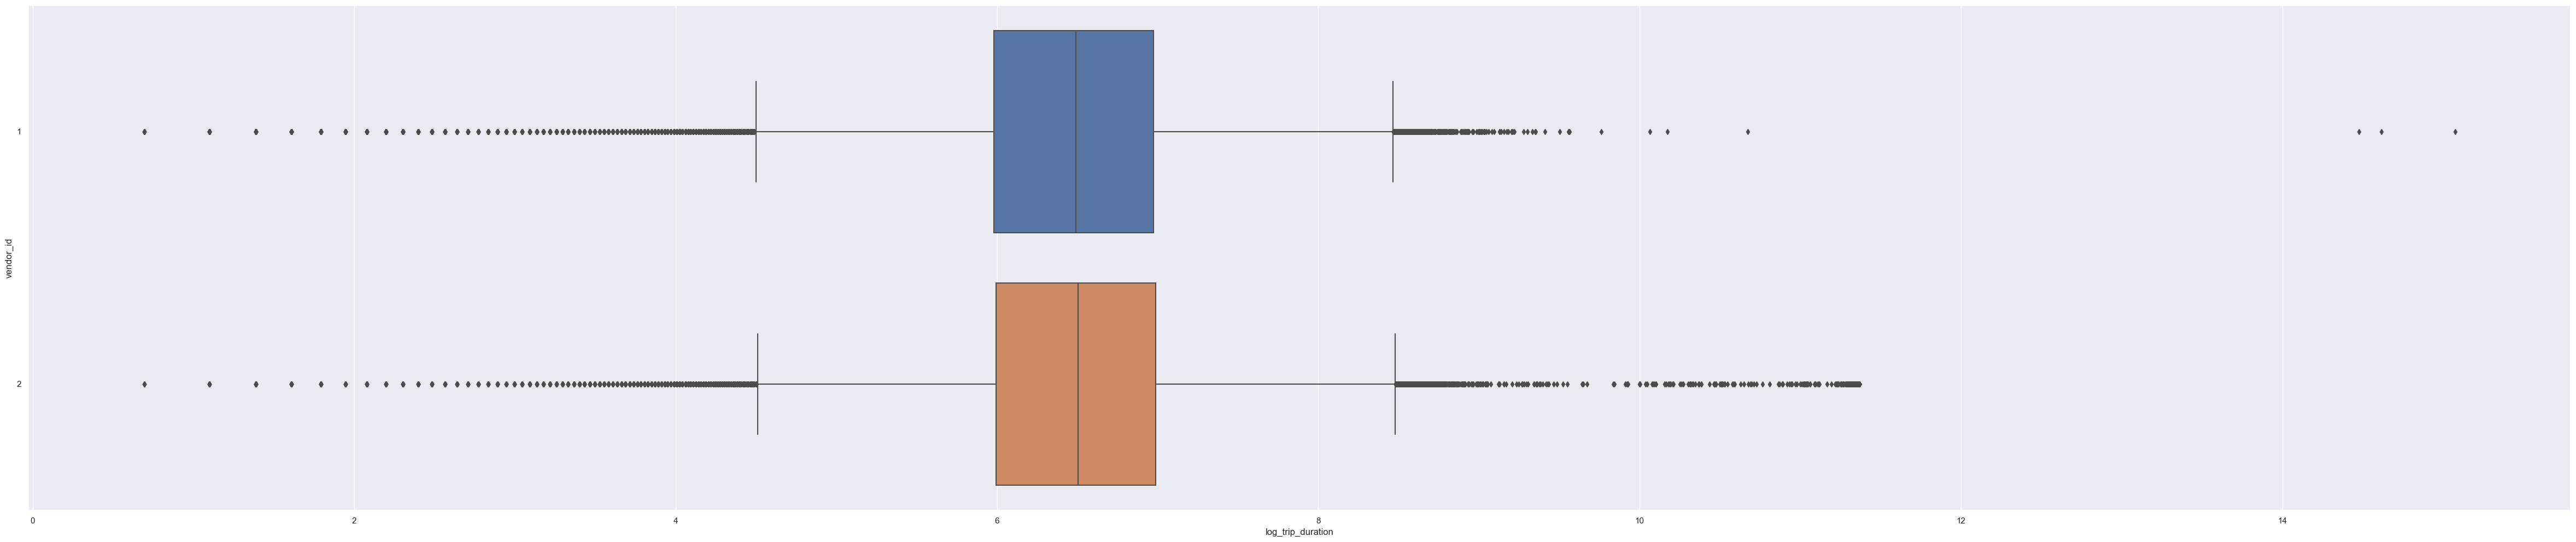

In [94]:
sns.boxplot(data=X_train, x=X_train["log_trip_duration"], y=X_train['vendor_id'])

<Axes: xlabel='log_trip_duration', ylabel='passenger_count'>

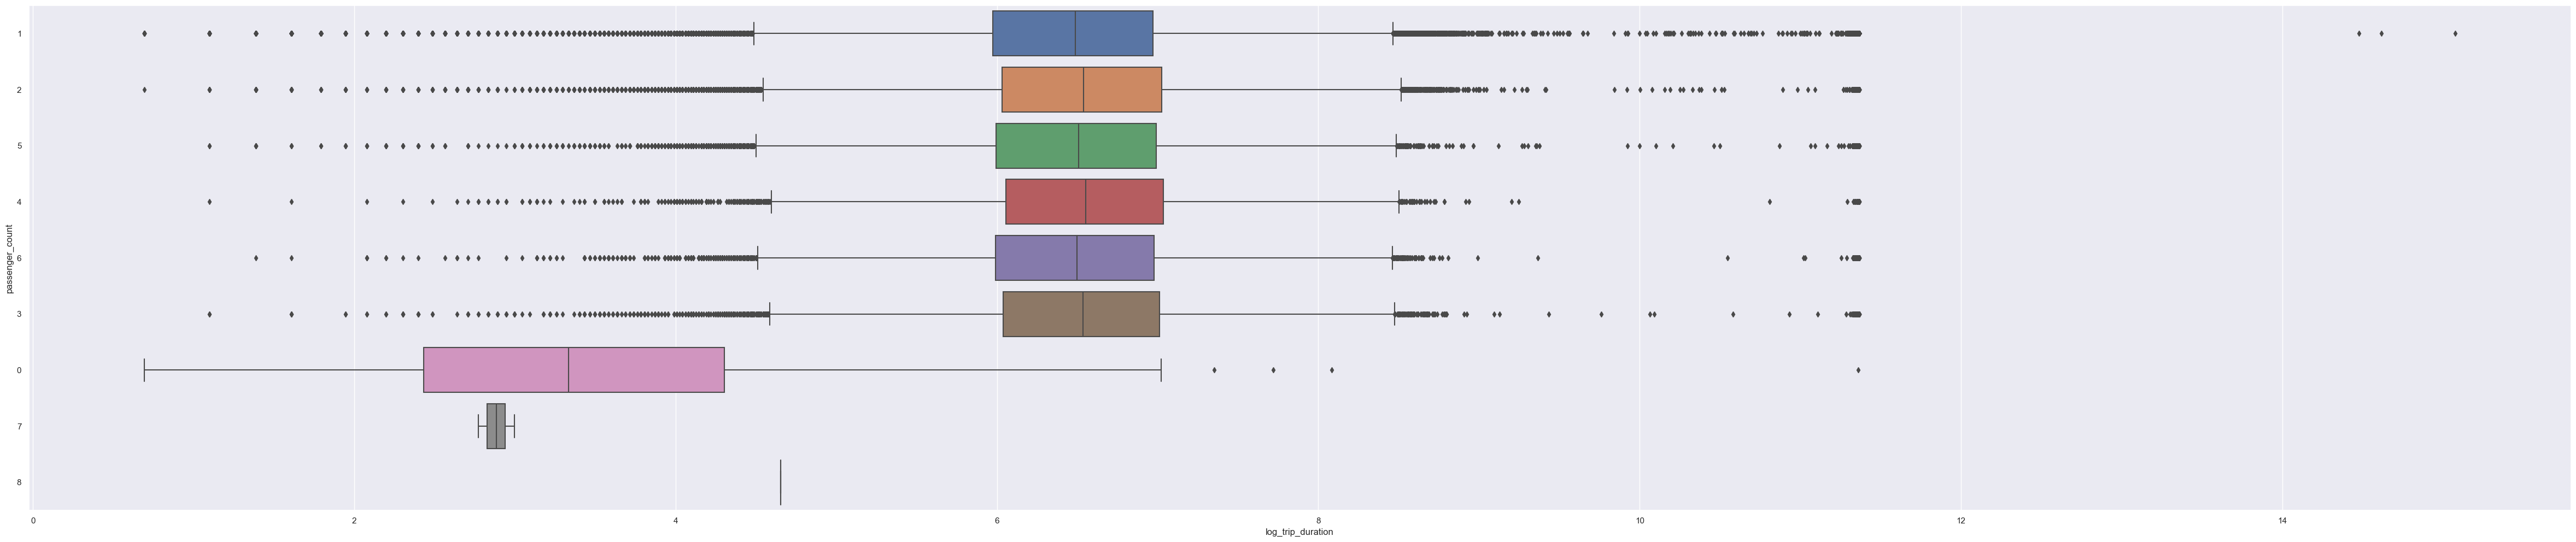

In [95]:
sns.boxplot(data=X_train, x=X_train["log_trip_duration"], y=X_train["passenger_count"])

<Axes: xlabel='log_trip_duration', ylabel='store_and_fwd_flag'>

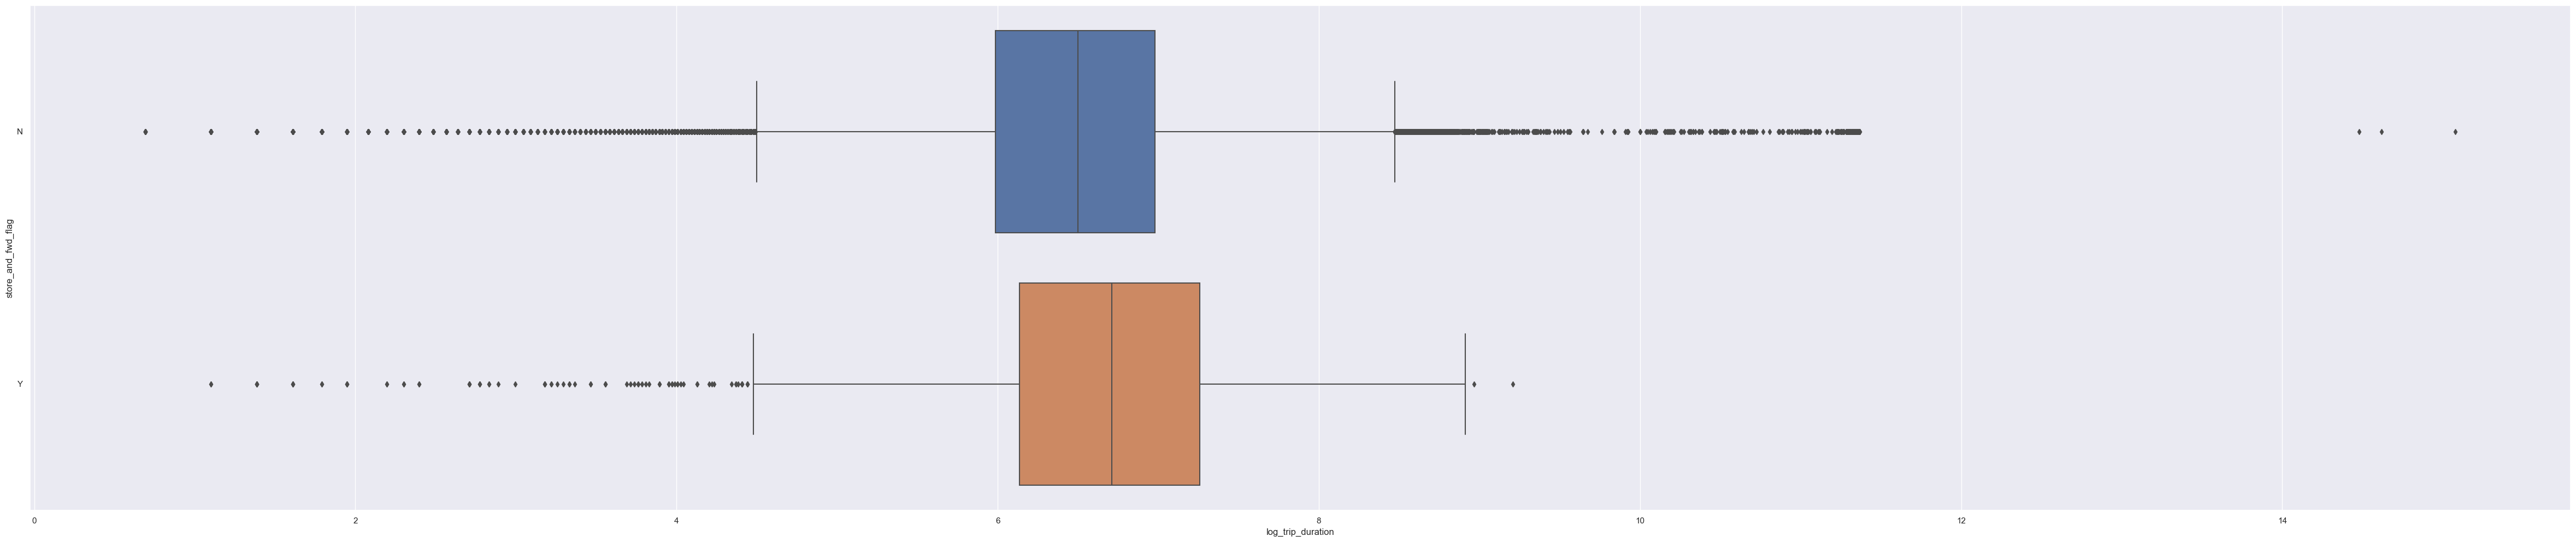

In [96]:
sns.boxplot(data=X_train, x="log_trip_duration", y="store_and_fwd_flag")

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [97]:
def get_binary(x):
    if ((x=="1") or (x!="N")): return "1"
    else: return "0"

X_train['wasVendor']=X_train['vendor_id'].apply(get_binary)
X_train['wasStore']=X_train['store_and_fwd_flag'].apply(get_binary)

X_test['wasVendor']=X_test['vendor_id'].apply(get_binary)
X_test['wasStore']=X_test['store_and_fwd_flag'].apply(get_binary)

df['wasVendor']=df['vendor_id'].apply(get_binary)
df['wasStore']=df['store_and_fwd_flag'].apply(get_binary)

X_train.head()

index         id vendor_id     pickup_datetime passenger_count  \
1215643  1215643  id2006587         1 2016-05-18 22:51:41               1   
1312402  1312402  id2894673         2 2016-06-07 11:07:36               1   
1242404  1242404  id1347586         2 2016-01-21 22:48:17               1   
1092817  1092817  id3196272         1 2016-02-17 16:43:46               1   
798698    798698  id1439842         2 2016-02-15 17:37:53               2   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1215643        -73.955452        40.779224         -73.944916   
1312402        -73.954910        40.777668         -73.974907   
1242404        -73.955841        40.785278         -73.954247   
1092817        -73.952812        40.783035         -73.955795   
798698         -73.984200        40.743446         -73.995033   

         dropoff_latitude store_and_fwd_flag  ...  log_haversine  probki  \
1215643         40.791496                  N  ...       0.487081       0   
1312402         40.758846                  N  ...       0.988151       1   
1242404         40.800652                  N  ...       0.539231       0   
1092817         40.778934                  N  ...      -0.652796       1   
798698          40.744778                  N  ...      -0.078378       1   

         Aeroport_Kennedy_start  Aeroport_Kennedy_end  Aeroport_Guardia_start  \
1215643                       0                     0                       0   
1312402                       0                     0                       0   
1242404                       0                     0                       0   
1092817                       0                     0                       0   
798698                        0                     0                       0   

        Aeroport_Guardia_end  start  end wasVendor wasStore  
1215643                    0     18   -1         1        0  
1312402                    0     19   14         1        0  
1242404                    0     18   -1         1        0  
1092817                    0     19   18         1        0  
798698                     0      9    9         1        0  

[5 rows x 27 columns]

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12.** Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [98]:
X_Ridge = X_train[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','wasVendor','wasStore','passenger_count']]
X_Ridge_test = X_test[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','wasVendor','wasStore','passenger_count']]

In [99]:
numeric_data = X_Ridge.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical = list(X_Ridge.dtypes[X_Ridge.dtypes == "object"].index)
X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\1856374358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\1856374358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")


In [100]:
# Создание трансформера для обработки данных в колонках
column_transformer = ColumnTransformer([
    # Применение OneHotEncoder для категориальных признаков
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),

    # Применение StandardScaler для численных признаков
    ('scaling', StandardScaler(), numeric_features)
])

# Создание конвейера обработки данных и обучения модели
pipeline = Pipeline(steps=[
    # Шаг 1: Преобразование данных (ohe_and_scaling)
    ('ohe_and_scaling', column_transformer),

    # Шаг 2: Обучение модели регрессии (Ridge)
    ('regression', Ridge())
])


In [101]:
# Обучение модели с использованием созданного конвейера
model = pipeline.fit(
    X_Ridge,  # Обучающие данные (входные признаки)
    X_train['log_trip_duration']  # Целевая переменная (логарифм продолжительности поездки)
)

# Выполнение предсказания на тестовых данных
y_pred = model.predict(X_Ridge_test)  # Предсказание для тестового набора

# Вычисление и вывод RMSE (корня из среднеквадратичной ошибки)
print("Test RMSE = %.4f" % mean_squared_error(
    X_test['log_trip_duration'],  # Истинные значения
    y_pred,  # Предсказанные значения
    squared=False  # Аргумент для вычисления RMSE вместо MSE
))

# Вычисление и вывод RMSLE (корня из среднеквадратичной логарифмической ошибки)
print("Test RMSLE = %.4f" % mean_squared_log_error(
    X_test['log_trip_duration'],  # Истинные значения
    y_pred,  # Предсказанные значения
    squared=False  # Аргумент для вычисления RMSLE вместо MSLE
))


Test RMSE = 0.4809
Test RMSLE = 0.0690


In [102]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 4395.5764
Test RMSLE = 0.4809


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель

**Задание 13.** В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

In [103]:
df.head()

index         id  vendor_id     pickup_datetime  passenger_count  \
0      0  id2875421          2 2016-03-14 17:24:55                1   
1      1  id2377394          1 2016-06-12 00:43:35                1   
2      2  id3858529          2 2016-01-19 11:35:24                1   
3      3  id3504673          2 2016-04-06 19:32:31                1   
4      4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  ...  log_haversine  probki  Aeroport_Kennedy_start  \
0                  N  ...       0.404478       1                       0   
1                  N  ...       0.590842       0                       0   
2                  N  ...       1.853967       1                       0   
3                  N  ...       0.395750       0                       0   
4                  N  ...       0.172766       1                       0   

   Aeroport_Kennedy_end  Aeroport_Guardia_start  Aeroport_Guardia_end start  \
0                     0                       0                     0    13   
1                     0                       0                     0     5   
2                     0                       0                     0    13   
3                     0                       0                     0     0   
4                     0                       0                     0    -1   

   end  wasVendor wasStore  
0   14          1        0  
1    4          1        0  
2    0          1        0  
3    0          1        0  
4   18          1        0  

[5 rows x 28 columns]

<Axes: xlabel='log_trip_duration', ylabel='Count'>

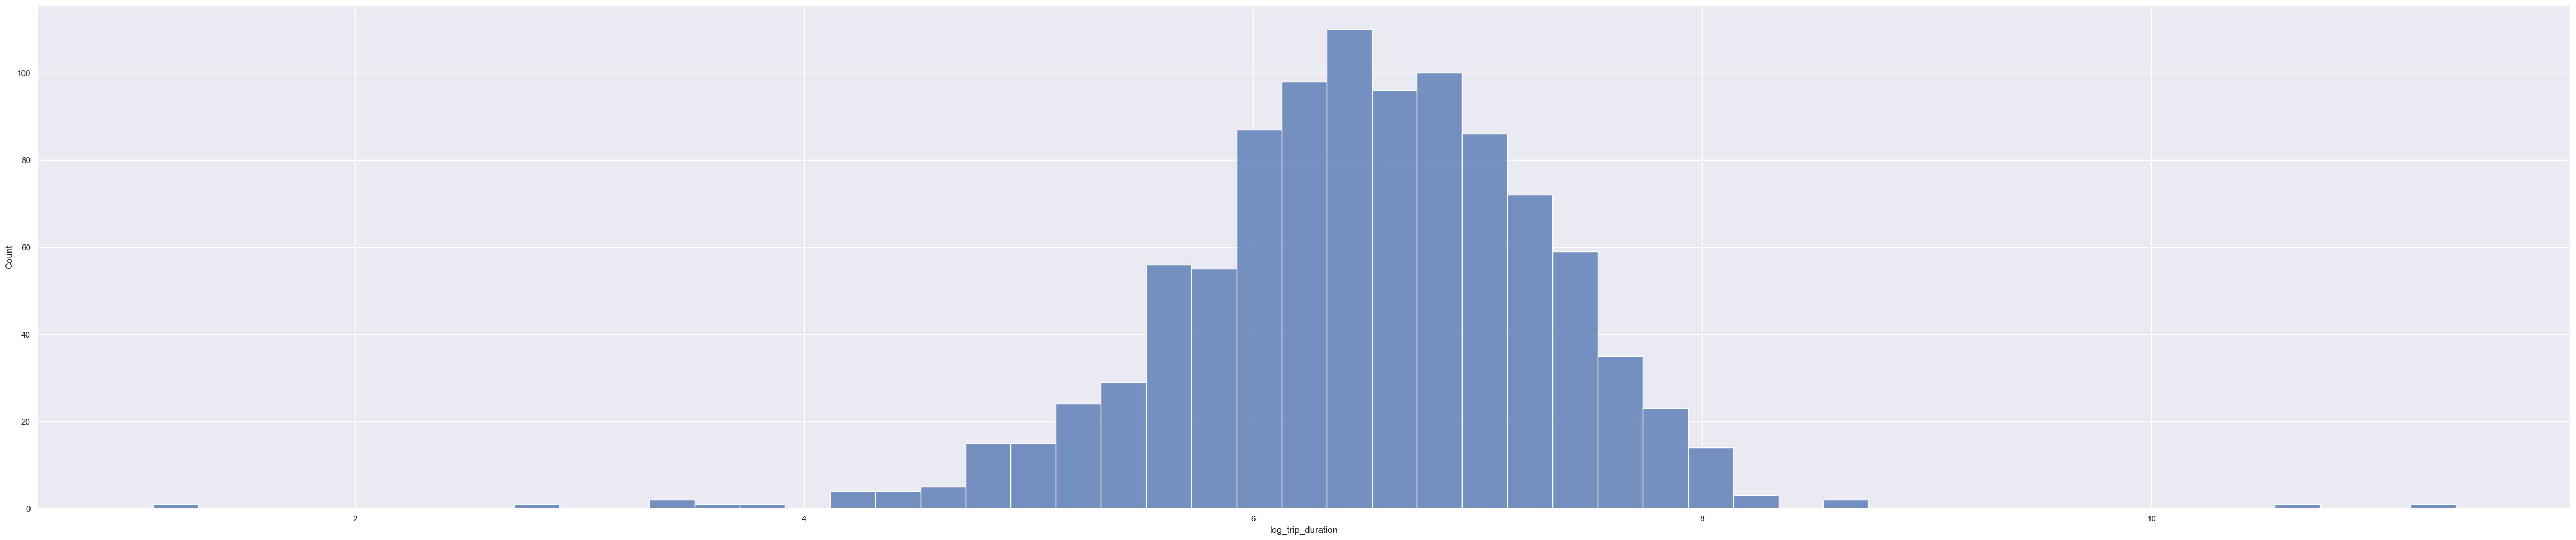

In [104]:
sns.histplot(data=df.sample(1000), x="log_trip_duration")

<Axes: >

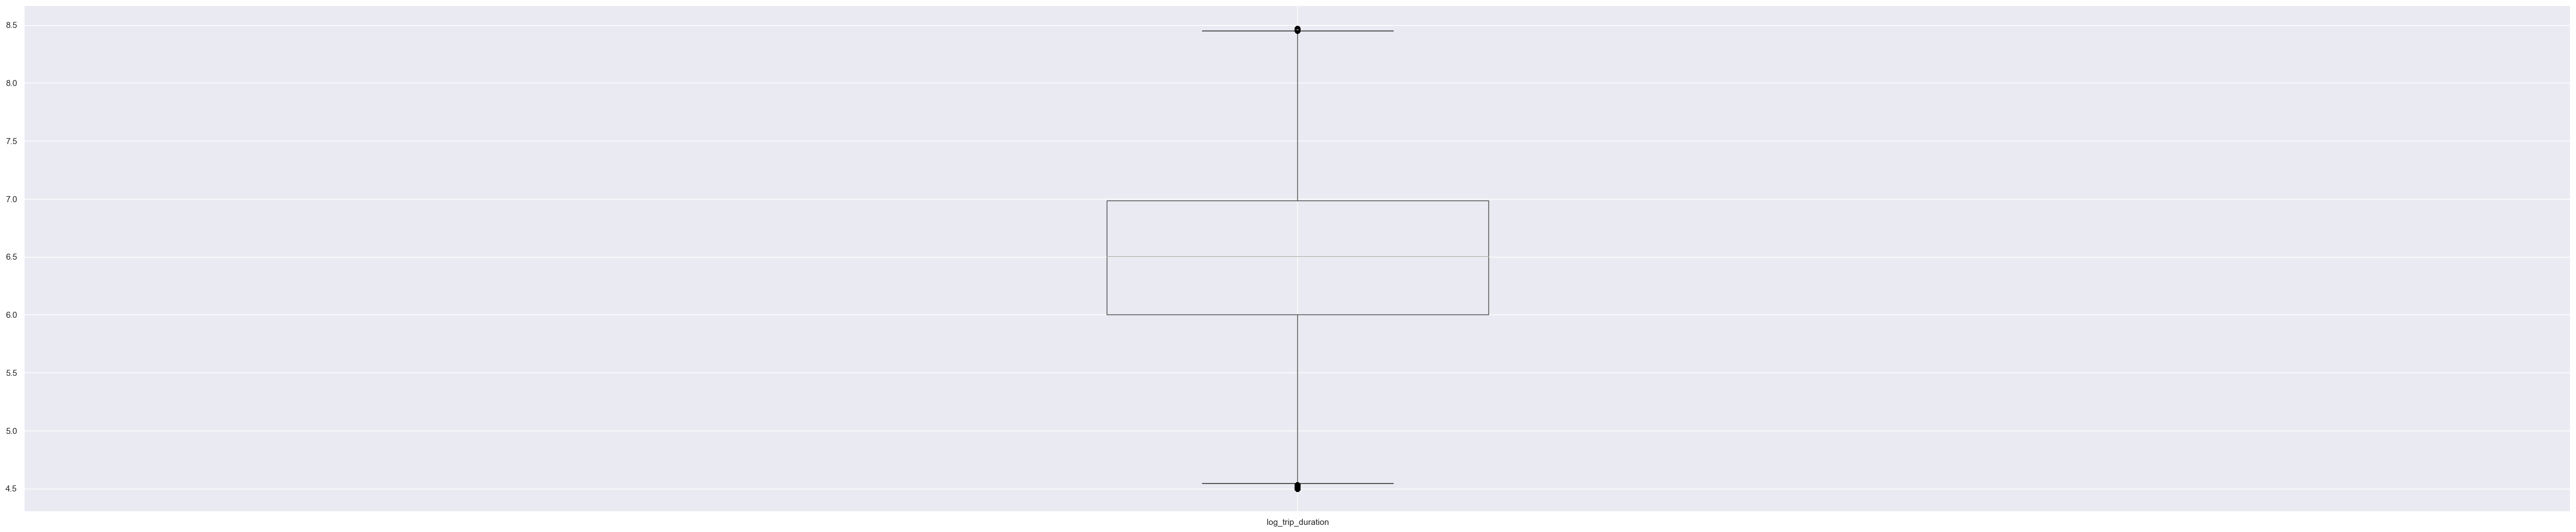

In [105]:
Q1 =  df['log_trip_duration'].quantile(0.25)
Q3 = df['log_trip_duration'].quantile(0.75)
IQR = Q3 - Q1
df_IQR = df[(df['log_trip_duration'] > (Q1-1.5*IQR)) & (df['log_trip_duration'] < (Q3+1.5*IQR))]
df_IQR.boxplot(column="log_trip_duration")

<Axes: xlabel='log_haversine', ylabel='Count'>

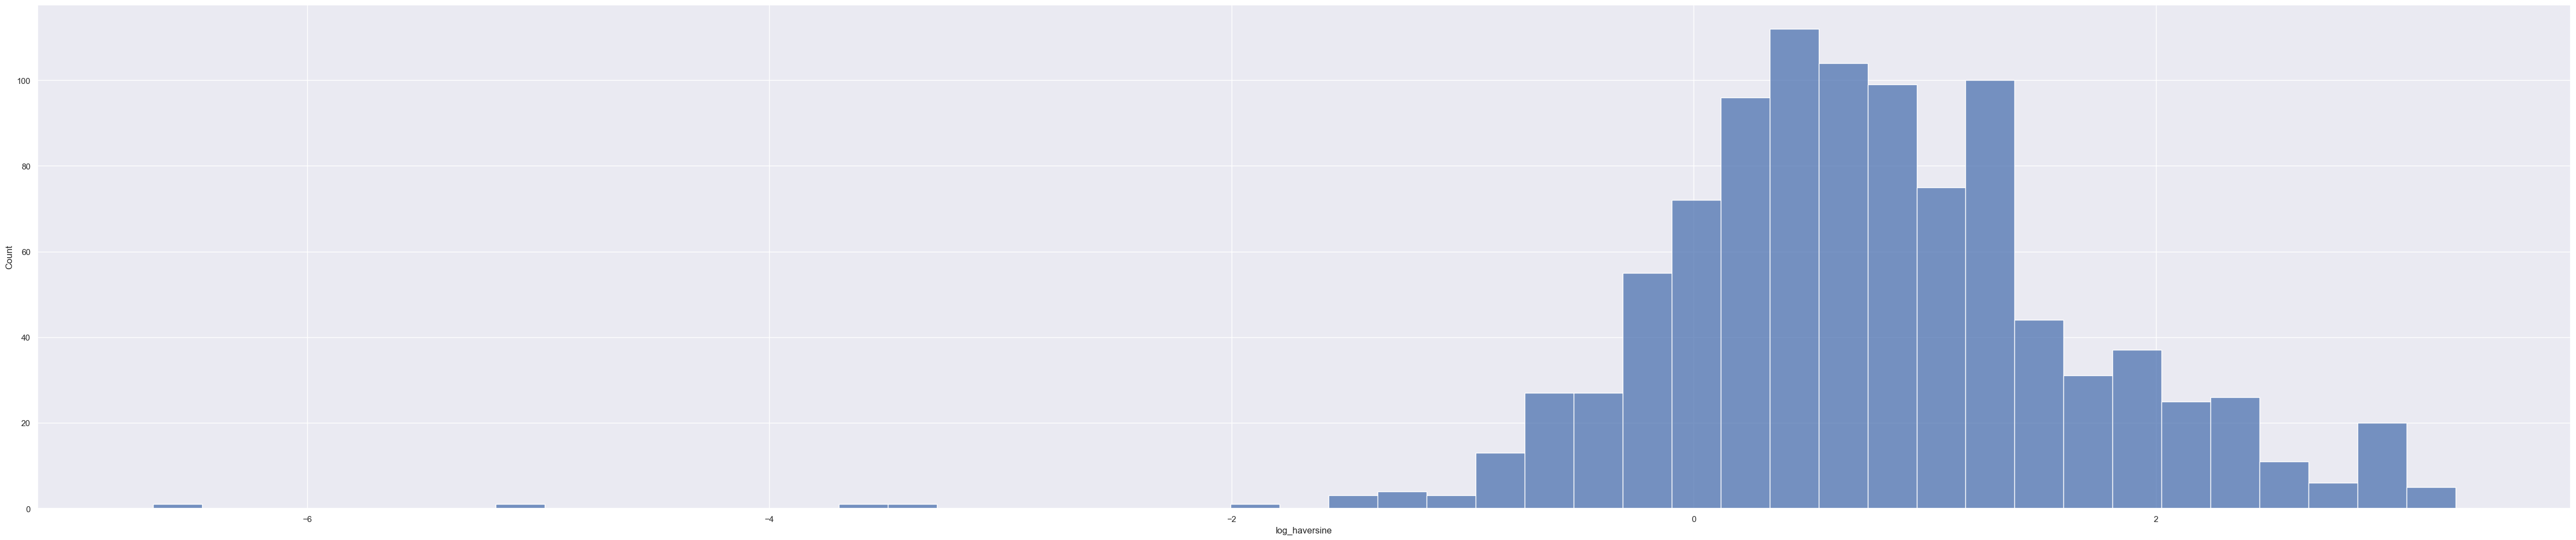

In [106]:
sns.histplot(data=df.sample(1000), x="log_haversine")

<Axes: >

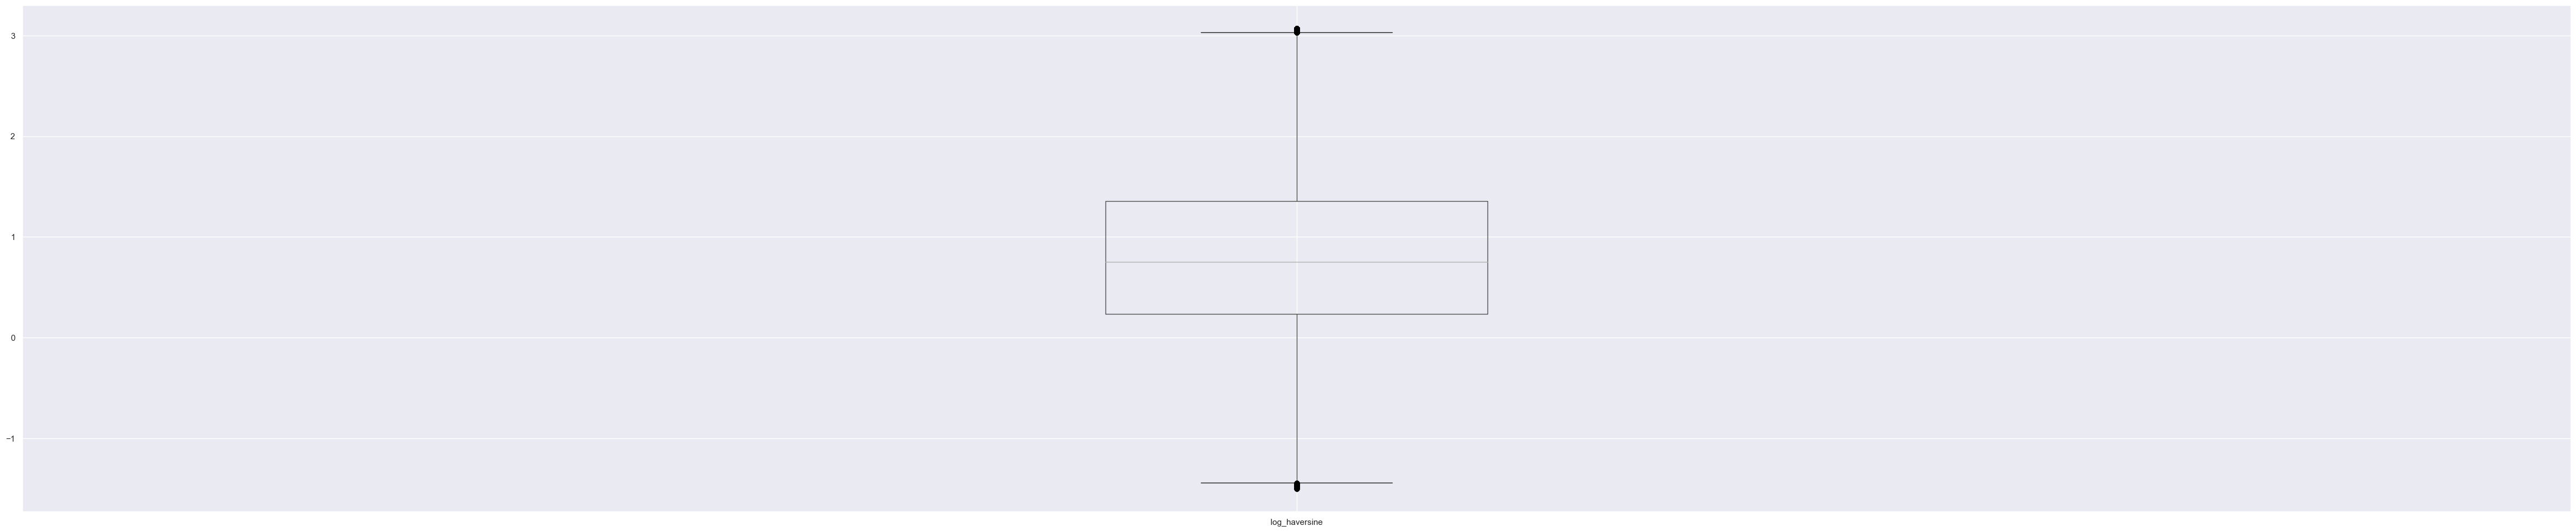

In [107]:
Q1 =  df['log_haversine'].quantile(0.25)
Q3 = df['log_haversine'].quantile(0.75)
IQR = Q3 - Q1
df_IQR = df_IQR[(df_IQR['log_haversine'] > (Q1-1.5*IQR)) & (df_IQR['log_haversine'] < (Q3+1.5*IQR))]
df_IQR.boxplot(column="log_haversine")

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [108]:
df_IQR.dtypes

index                              int64
id                                object
vendor_id                          int64
pickup_datetime           datetime64[ns]
passenger_count                    int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
store_and_fwd_flag                object
trip_duration                      int64
log_trip_duration                float64
day_week                           int64
month                              int64
hour                               int64
day_year                           int64
anomal                            object
haversine                        float64
log_haversine                    float64
probki                            object
Aeroport_Kennedy_start            object
Aeroport_Kennedy_end              object
Aeroport_Guardia_start            object
Aeroport_Guardia_end              object
start           

In [109]:
df_IQR.store_and_fwd_flag.value_counts()

N    1414884
Y       7685
Name: store_and_fwd_flag, dtype: int64

In [110]:
df_IQR.probki.value_counts()

0    717747
1    704822
Name: probki, dtype: int64

In [111]:
#'Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   #'Aeroport_Guardia_start','Aeroport_Guardia_end',
df_IQR["Aeroport_Kennedy_start"].value_counts()

0    1415694
1       6875
Name: Aeroport_Kennedy_start, dtype: int64

In [112]:
df_IQR["Aeroport_Kennedy_end"].value_counts()

0    1421534
1       1035
Name: Aeroport_Kennedy_end, dtype: int64

In [113]:
df_IQR["Aeroport_Guardia_start"].value_counts()

0    1422567
1          2
Name: Aeroport_Guardia_start, dtype: int64

In [114]:
df_IQR["Aeroport_Guardia_end"].value_counts()

0    1422568
1          1
Name: Aeroport_Guardia_end, dtype: int64

In [115]:
df_IQR["anomal"].value_counts()

0    1412265
1      10304
Name: anomal, dtype: int64

In [116]:
df_IQR["redkie"]="0"
df_IQR.loc[(df["Aeroport_Kennedy_start"]=="1") | (df["Aeroport_Kennedy_end"]=="1") | (df["Aeroport_Guardia_start"]=="1") | (df["Aeroport_Guardia_end"]=="1")| (df.anomal=="1"),"redkie"]="1"

In [117]:
df_IQR.head()

index         id  vendor_id     pickup_datetime  passenger_count  \
0      0  id2875421          2 2016-03-14 17:24:55                1   
1      1  id2377394          1 2016-06-12 00:43:35                1   
2      2  id3858529          2 2016-01-19 11:35:24                1   
3      3  id3504673          2 2016-04-06 19:32:31                1   
4      4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  ...  probki  Aeroport_Kennedy_start  \
0                  N  ...       1                       0   
1                  N  ...       0                       0   
2                  N  ...       1                       0   
3                  N  ...       0                       0   
4                  N  ...       1                       0   

   Aeroport_Kennedy_end  Aeroport_Guardia_start  Aeroport_Guardia_end  start  \
0                     0                       0                     0     13   
1                     0                       0                     0      5   
2                     0                       0                     0     13   
3                     0                       0                     0      0   
4                     0                       0                     0     -1   

  end  wasVendor  wasStore redkie  
0  14          1         0      0  
1   4          1         0      0  
2   0          1         0      0  
3   0          1         0      0  
4  18          1         0      0  

[5 rows x 29 columns]

In [118]:
X = df_IQR.drop(columns=["trip_duration"])
y = df_IQR['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)

In [119]:
X_Ridge = X_train[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','redkie']]
X_Ridge_test = X_test[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','redkie']]
numeric_data = X_Ridge.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical = list(X_Ridge.dtypes[X_Ridge.dtypes == "object"].index)
X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\2001154040.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\2001154040.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")


In [120]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [121]:
model = pipeline.fit(X_Ridge,
                     X_train['log_trip_duration'])
y_pred = model.predict(X_Ridge_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4086
Test RMSLE = 0.0564


In [122]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 358.6659
Test RMSLE = 0.4086


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14.** После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [123]:
print("Size before OneHot:", X_Ridge.shape)
print("Size after OneHot:", column_transformer.transform(X_Ridge).shape)

Size before OneHot: (995798, 14)
Size after OneHot: (995798, 21)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Стало ли лучше?

In [124]:
from sklearn.linear_model import Lasso
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

In [125]:
model = pipeline.fit(X_Ridge,
                     X_train['log_trip_duration'])
y_pred = model.predict(X_Ridge_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.7033
Test RMSLE = 0.0955


In [126]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 636.6563
Test RMSLE = 0.7033


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальное значение параметра регуляризации (по логарифмической сетке), на тестовой выборке измерьте качество полученной модели.

In [127]:
from sklearn.model_selection import GridSearchCV

train, validate = np.split(X_train.sample(frac=1, random_state=42), [int(.8*len(X_train))])

alphas = np.logspace(-2, 3, 10)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)

In [128]:
validate_search = validate[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','redkie']]
validate_search.head()

day_week  month  hour  day_year anomal probki Aeroport_Kennedy_start  \
712958          4      6    17       176      0      1                      0   
1255202         1      6    11       173      0      1                      0   
565027          0      4    15       109      0      1                      0   
1114408         5      4    23       114      0      0                      0   
579296          5      2    18        44      0      1                      0   

        Aeroport_Kennedy_end Aeroport_Guardia_start Aeroport_Guardia_end  \
712958                     0                      0                    0   
1255202                    0                      0                    0   
565027                     0                      0                    0   
1114408                    0                      0                    0   
579296                     0                      0                    0   

         log_haversine  start  end redkie  
712958        2.177217     -1   14      0  
1255202       0.654531      5    0      0  
565027        1.256685      5    9      0  
1114408       1.166172     17   10      0  
579296       -0.598396     14   13      0

Best alpha = 0.4642


Text(0, 0.5, 'CV score')

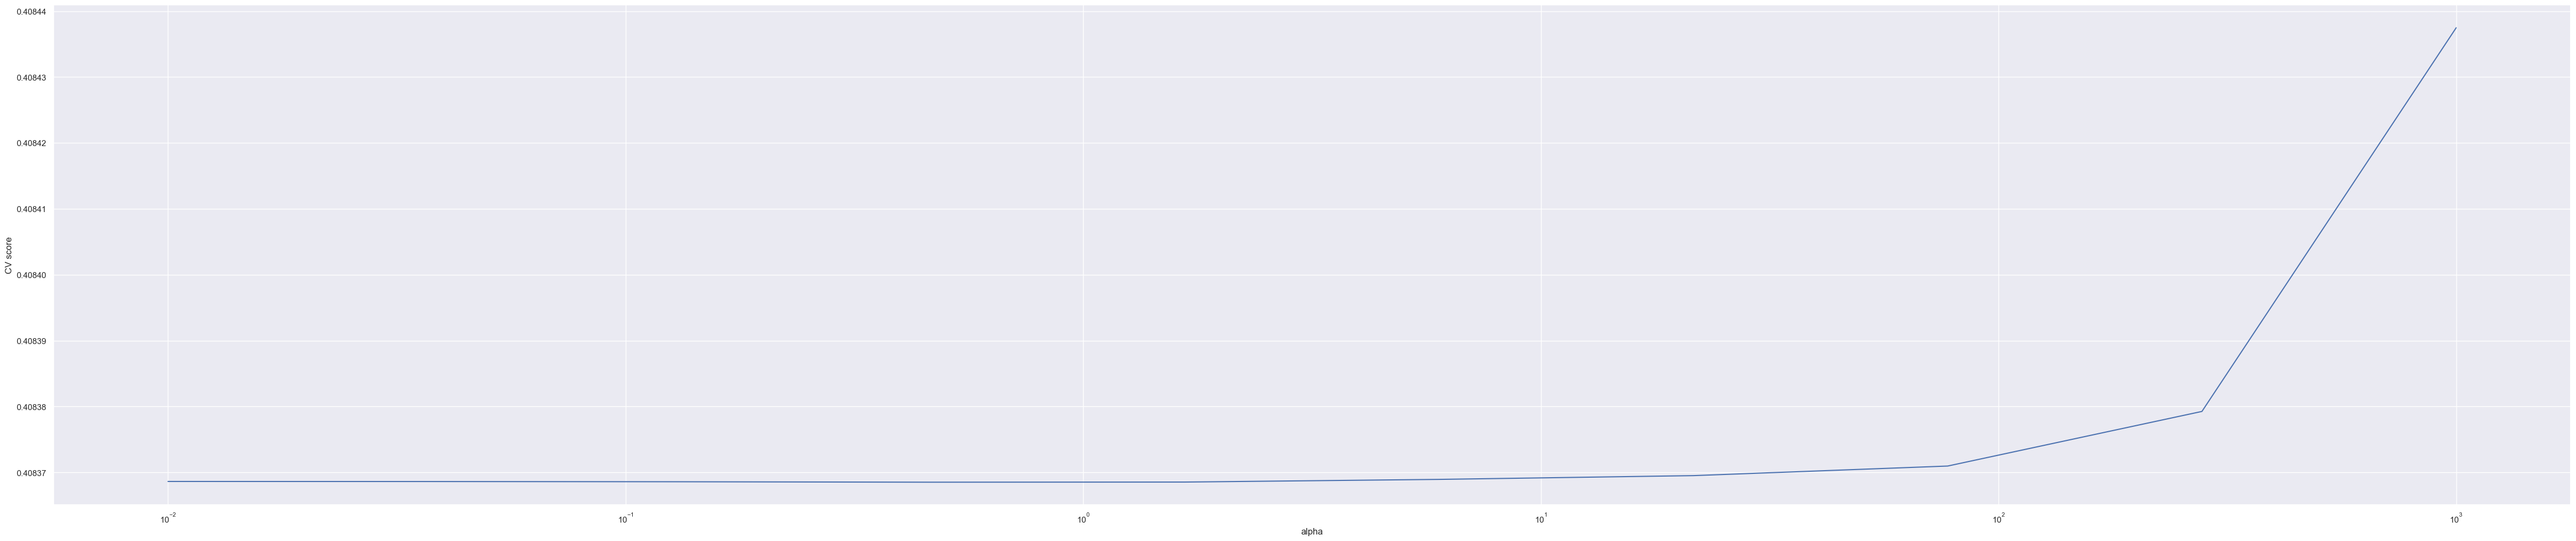

In [129]:
searcher.fit(validate_search, validate['log_trip_duration'])

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [130]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])
train_sample = train[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','redkie']]
model = simple_pipeline.fit(train_sample,
                     train['log_trip_duration'])
y_pred = model.predict(X_Ridge_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4086
Test RMSLE = 0.0564


In [131]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 358.6468
Test RMSLE = 0.4086


Для каждого перебранного `alpha` посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`.

In [132]:
ridge_zeros = np.sum(simple_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)

Zero weights in Ridge: 0


In [133]:
alphas

array([1.00000000e-02, 3.59381366e-02, 1.29154967e-01, 4.64158883e-01,
       1.66810054e+00, 5.99484250e+00, 2.15443469e+01, 7.74263683e+01,
       2.78255940e+02, 1.00000000e+03])

In [134]:
simple_pipeline.steps[-1][-1].coef_

array([-2.95701462e-02, -7.35220406e-03,  3.43012922e-02,  3.36675099e-02,
       -1.11292558e-02,  1.13808922e-01, -8.75014523e-03, -4.29482020e-03,
        7.09320769e-04, -4.41681573e-04,  5.72220112e-01, -6.93490817e-03,
        4.32803864e-03, -2.80342805e-03])

In [135]:
result = []
for x in alphas:
  pipeline_an = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', Ridge(x))
  ])
  model = pipeline_an.fit(train_sample,
                     train['log_trip_duration'])
  ridge_zeros = np.sum(pipeline_an.steps[-1][-1].coef_ == 0)
  result.append(ridge_zeros)

C:\Users\Egor\anaconda3\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


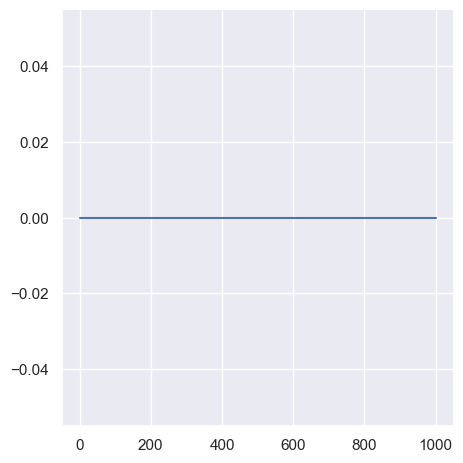

In [136]:
sns.relplot(x=alphas,y=result,ci=None,kind='line')

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15.** Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими редкими парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [137]:
df_IQR.head()

index         id  vendor_id     pickup_datetime  passenger_count  \
0      0  id2875421          2 2016-03-14 17:24:55                1   
1      1  id2377394          1 2016-06-12 00:43:35                1   
2      2  id3858529          2 2016-01-19 11:35:24                1   
3      3  id3504673          2 2016-04-06 19:32:31                1   
4      4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  ...  probki  Aeroport_Kennedy_start  \
0                  N  ...       1                       0   
1                  N  ...       0                       0   
2                  N  ...       1                       0   
3                  N  ...       0                       0   
4                  N  ...       1                       0   

   Aeroport_Kennedy_end  Aeroport_Guardia_start  Aeroport_Guardia_end  start  \
0                     0                       0                     0     13   
1                     0                       0                     0      5   
2                     0                       0                     0     13   
3                     0                       0                     0      0   
4                     0                       0                     0     -1   

  end  wasVendor  wasStore redkie  
0  14          1         0      0  
1   4          1         0      0  
2   0          1         0      0  
3   0          1         0      0  
4  18          1         0      0  

[5 rows x 29 columns]

In [138]:
temp = pd.DataFrame(df_IQR.groupby(['start','end']).index.count().sort_values(ascending=False)[:100])
temp=temp.reset_index()
temp.head()

start  end  index
0     -1   -1  66987
1      9    9  55220
2      9   13  34896
3     14   14  33960
4     13    9  31347

In [139]:
temp_set = list(zip(temp.start, temp.end))
df_IQR['set'] = list(zip(df_IQR.start, df_IQR.end))

df_IQR['poezdki']="-1"
df_IQR.loc[(df_IQR["set"].isin(temp_set)),"poezdki"]="1"
df_IQR.head()

index         id  vendor_id     pickup_datetime  passenger_count  \
0      0  id2875421          2 2016-03-14 17:24:55                1   
1      1  id2377394          1 2016-06-12 00:43:35                1   
2      2  id3858529          2 2016-01-19 11:35:24                1   
3      3  id3504673          2 2016-04-06 19:32:31                1   
4      4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  ...  Aeroport_Kennedy_end  Aeroport_Guardia_start  \
0                  N  ...                     0                       0   
1                  N  ...                     0                       0   
2                  N  ...                     0                       0   
3                  N  ...                     0                       0   
4                  N  ...                     0                       0   

   Aeroport_Guardia_end  start  end  wasVendor wasStore  redkie       set  \
0                     0     13   14          1        0       0  (13, 14)   
1                     0      5    4          1        0       0    (5, 4)   
2                     0     13    0          1        0       0   (13, 0)   
3                     0      0    0          1        0       0    (0, 0)   
4                     0     -1   18          1        0       0  (-1, 18)   

  poezdki  
0       1  
1       1  
2       1  
3       1  
4       1  

[5 rows x 31 columns]

Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [140]:
X = df_IQR.drop(columns=["trip_duration"])
y = df_IQR['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)

In [141]:
X_train.head()

index         id  vendor_id     pickup_datetime  passenger_count  \
298586    298586  id1338425          1 2016-05-09 08:54:18                1   
255946    255946  id0362276          2 2016-05-31 08:19:11                1   
35987      35987  id1687791          2 2016-03-25 14:43:43                1   
76342      76342  id1682923          1 2016-01-19 21:13:52                1   
1289173  1289173  id0158312          1 2016-02-12 04:21:05                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
298586         -73.976959        40.788097         -73.974777   
255946         -73.980705        40.720482         -73.973038   
35987          -73.991371        40.732521         -73.985680   
76342          -73.987175        40.750774         -73.970367   
1289173        -73.988426        40.731930         -73.985291   

         dropoff_latitude store_and_fwd_flag  ...  Aeroport_Kennedy_end  \
298586          40.779255                  N  ...                     0   
255946          40.753937                  N  ...                     0   
35987           40.727798                  N  ...                     0   
76342           40.784916                  N  ...                     0   
1289173         40.717457                  N  ...                     0   

         Aeroport_Guardia_start  Aeroport_Guardia_end  start  end wasVendor  \
298586                        0                     0     17   18         1   
255946                        0                     0      1   10         1   
35987                         0                     0      5    5         1   
76342                         0                     0      9   18         1   
1289173                       0                     0      5    1         1   

         wasStore  redkie       set poezdki  
298586          0       0  (17, 18)       1  
255946          0       0   (1, 10)      -1  
35987           0       0    (5, 5)       1  
76342           0       0   (9, 18)       1  
1289173         0       0    (5, 1)       1  

[5 rows x 30 columns]

In [142]:
X_Ridge = X_train[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','redkie','poezdki']]
X_Ridge_test = X_test[['day_week','month','hour','day_year','anomal','probki','Aeroport_Kennedy_start','Aeroport_Kennedy_end',
                   'Aeroport_Guardia_start','Aeroport_Guardia_end','log_haversine','start','end','redkie']]
numeric_data = X_Ridge.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical = list(X_Ridge.dtypes[X_Ridge.dtypes == "object"].index)
X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")

C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\2707911919.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge[categorical] = X_train[categorical].fillna("NotGiven")
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\2707911919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Ridge_test[categorical] = X_test[categorical].fillna("NotGiven")
C:\Users\Egor\AppData\Local\Temp\ipykernel_13148\2707911919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [143]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

In [144]:
model = pipeline.fit(X_Ridge,
                     X_train['log_trip_duration'])
y_pred = model.predict(X_Ridge_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4080
Test RMSLE = 0.0563


In [145]:
proverka = np.exp(y_pred)-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, proverka, squared=False))
print("Test RMSLE = %.4f" % mean_squared_log_error(y_test, proverka, squared=False))

Test RMSE = 357.5201
Test RMSLE = 0.4080
